# TFM UOC SALINIDAD EN EL VALLE DEL GUADALHORCE

In [1]:
#Se cargan las librerias que serán necesarias durante todo el desarrollo del script
import matplotlib as mpl
import numpy
from matplotlib.colors import ListedColormap
import datetime
from sklearn import tree
from datetime import datetime
import pydotplus
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.preprocessing import MinMaxScaler
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import missingno as msno
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/externals/six.py:28: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  warnings.warn("The module is deprecated in version 0.21 and will be removed "


# 1. Carga e integración de los datos

El primer paso que se deberán cargar e integrar los datos, ya que se encuentran dispersos en distintos ficheros.

A continuación se ejecuta un código que va recorriendo cada fichero CSV y va extrayendo la información de cada variable. Se crea una variable fecha, con el día, mes y año donde se ha tomada cada dato. 

Por lo tanto, crearemos un dataframe con todos los datos recogidos por la Junta de Andalucía en la explotación del sistema de presas del valle del guadalhorce. 

Adicionalmente se visualiza el dataset completo.

In [2]:
#Se leen los ficheros csv correspondientes.

df_list=[]
for anyo in range(12,20):
    path_csv=f'dataset/ESTADILLO_DE_EMBALSES_20{anyo}.csv'
    df=pd.read_csv(path_csv,sep=";",encoding = 'unicode_escape',decimal=',',thousands='.')
    #Se consolidan las variables Dia, Mes y Anyo en una variable de nueva creación llamada Fecha
    df['aux']=df['Anyo'].astype(str) + df['Mes'].astype(str).str.zfill(2)+ df['Dia'].astype(str).str.zfill(2)
    df['Fecha'] = pd.to_datetime(df['aux'], format='%Y%m%d')
    #Eliminamos la columna auxilir 'aux'
    del df['aux']
    #Se cambia el formato de YYYY-MM-DD a DD-MM-YYYY
    df['Fecha'] = df['Fecha'].dt.strftime('%d-%m-%Y')
    #Movemos el campo fecha al comienzo del dataframe
    indice=df['Fecha']
    df.drop(labels=['Fecha'], axis=1,inplace = True)
    df.insert(0, 'Fecha', indice)
    if anyo==14:
        df.drop(df.columns[[74,75,76,77,78,79,80,81,82,83,84,85,86]],axis = 1, inplace = True)
    if anyo==15:
        df.drop(df.columns[[74,75,76,77,78,79,80,81,82,83,84,85,86]],axis = 1, inplace = True)
    df_list.append(df)

df_data=pd.concat(df_list,ignore_index = True)
#Se consolidan todos los dataframes de la lista en un solo dataframe. Así, quedará un dataframe que contenga los
#datos díarios dentro de un año.
    
#Se utiliza para visualizar todas las filas del dataframe creado
pd.set_option('display.max_rows', df_data.shape[0]+1)

In [367]:
#Se visualiza el dataset completo
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2894 entries, 0 to 2893
Data columns (total 74 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Fecha                                                   2894 non-null   object 
 1   Dia                                                     2894 non-null   int64  
 2   Hora                                                    2894 non-null   object 
 3   Mes                                                     2894 non-null   int64  
 4   Anyo                                                    2894 non-null   int64  
 5   Lluvia                                                  569 non-null    float64
 6   Temperatura_Max                                         2894 non-null   float64
 7   Temperatura_Min                                         2894 non-null   float64
 8   Evaporacion                           

# 2. Limpieza de los datos

En este apartado se detectan todos los missing values existentes en el dataset y se aplican distintas estrategias de imputación de la variable etiquetada.

Se realiza una imputación de NAN de la variable Salinidad_guadalhorce usando regresion logística.

También se limpia el dataset de las columnas vacias, carácteres inadecuados y se cambia el separador decimal de "," a ".".

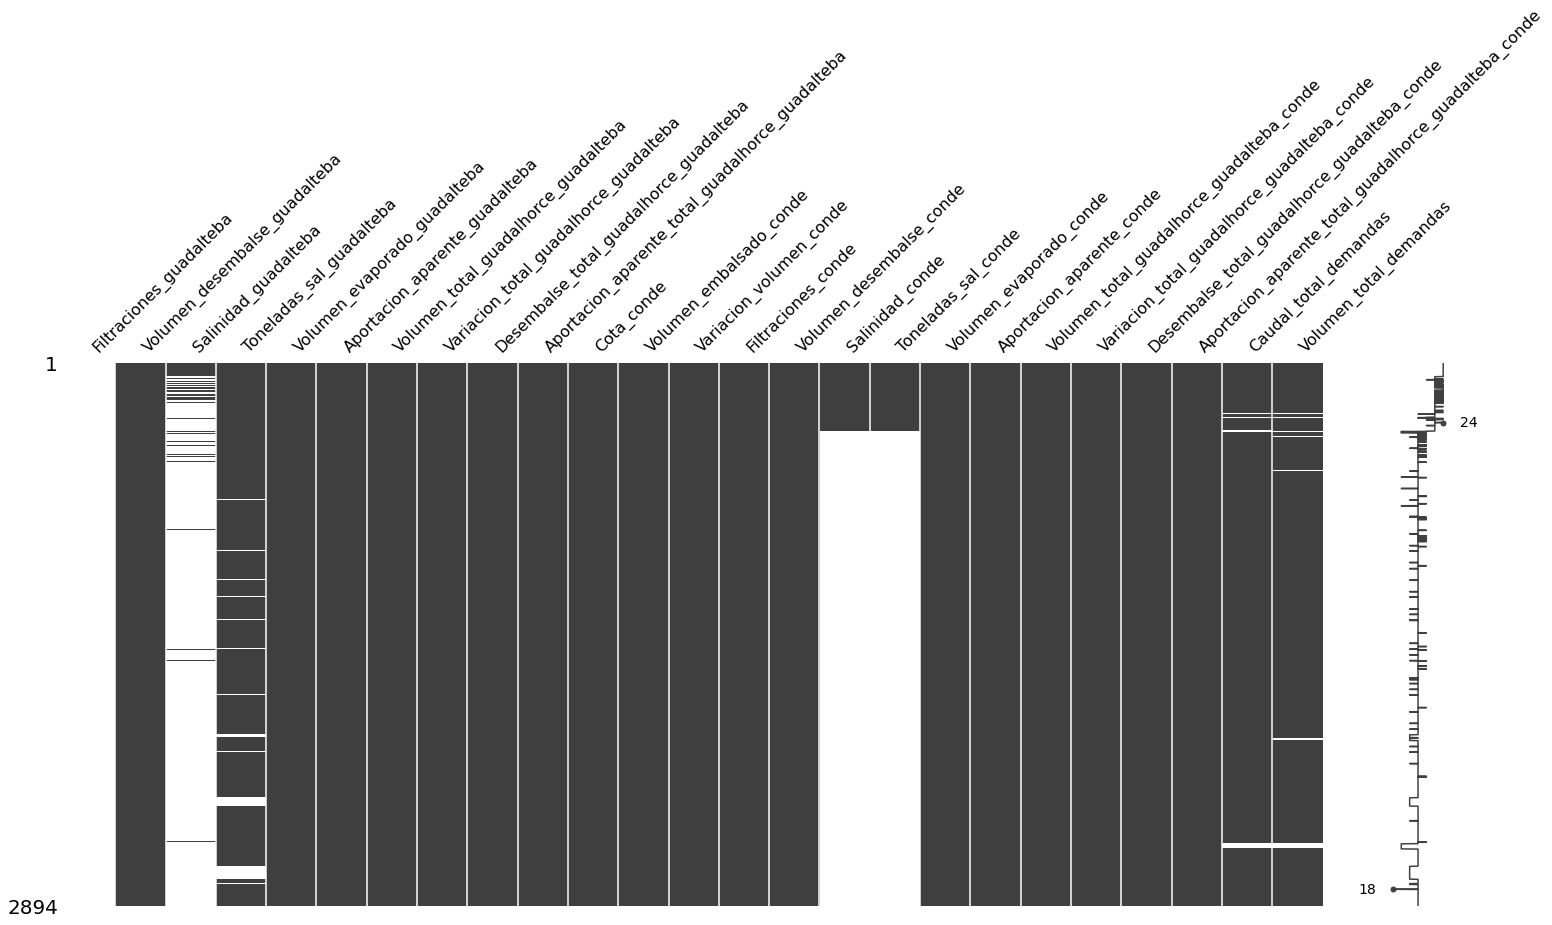

In [4]:
#Podemos visutalizar la cantidad de missing values presentes en el dataset (iterar para ver todas las columnas)
msno.matrix(df_data.iloc[:,25:50])

In [5]:
#Porcentaje de NAN en la variable etiquetada
salinidad_mezcla_percentage = 100*df_data['Salinidad_mezcla'].isnull().sum()/len(df_data['Salinidad_mezcla'])
salinidad_mezcla_percentage

59.43331029716655

In [6]:
#Eliminamos las columnas con todos los valores a 0
df_data=df_data.drop(df.columns[25], axis=1)
df_data=df_data.drop(df.columns[71], axis=1)
df_data=df_data.drop(df.columns[72], axis=1)
df_data=df_data.drop(df.columns[73], axis=1)

In [7]:
#Se crea la variable df_dam que contiene todos los datos de la explotación de las presas del valle del guadalhorce
df_dam=df_data
#Se elimina un valor que está dando error
indexNames = df_dam[df_dam['Salinidad_mezcla'] == '1,170' ].index
df_dam.drop(indexNames , inplace=True)

#Ajustamos el tipo de la variable Salinidad_mezcla para poder procesarla
df_dam['Salinidad_mezcla']=df_dam['Salinidad_mezcla'].astype(str).astype(float)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [8]:
################-------------------------IMPUTACIÓN NAN EN SALINIDAD MEZCLA------------------###################

#Activar solamente un tipo de imputación.

#1) BORRAR LAS FILAS QUE CONTIENEN NAN
#df_dam.dropna(subset=['Salinidad_mezcla'],inplace=True)


#2) REGRESOR LINEAL PARA PREDECIR LOS VALORES DE NAN
#cols_sm=["Cota_guadalhorce","Cota_guadalteba","Volumen_total_guadalhorce_guadalteba_conde","Desembalse_total_guadalhorce_guadalteba_conde"
      #,"Salinidad_mezcla"]

#df_sm=df_dam[cols_sm]
#test_df_sm=df_sm[df_sm["Salinidad_mezcla"].isnull()]
#df_sm=df_sm.dropna()

#ynan_train_sm=df_sm["Salinidad_mezcla"]
#Xnan_train_sm=df_sm.drop("Salinidad_mezcla",axis=1)
#Xnan_test_sm=test_df_sm.drop("Salinidad_mezcla",axis=1)

#Recurrimos a la regresión logistica para predecir el valor de los NAN.
#lr_sm=LinearRegression()
#lr_sm.fit(Xnan_train_sm, ynan_train_sm)
#ynan_pred_sm=lr_sm.predict(Xnan_test_sm)

#Se sustituyen los valores NAN por sus predicciones
#df_dam.loc[df_dam.Salinidad_mezcla.isnull(),'Salinidad_mezcla']=ynan_pred_sm

#3) IMPUTACIÓN CON MEDIA
#df_dam['Salinidad_mezcla'].fillna((df_dam['Salinidad_mezcla'].mean()),inplace=True)

#4) IMPUTACIÓN CON MEDIANA (con este obtenemos mas que con la predicción)
#df_dam['Salinidad_mezcla'].fillna((df_dam['Salinidad_mezcla'].median()),inplace=True)

#5) IMPUTACIÓN CON ROLLING MEAN (y eliminación de los NANs restantes)
#window = 30 # 30 dias de observación
#df_dam['Salinidad_mezcla'].fillna((df_dam['Salinidad_mezcla'].rolling(window,min_periods=1,).mean()),inplace=True)
#df_dam.dropna(subset=['Salinidad_mezcla'],inplace=True)

#6) IMPUTACIÓN CON ROLLING MEDIAN
#window = 30 # 30 dias de observación
#df_dam['Salinidad_mezcla'].fillna((df_dam['Salinidad_mezcla'].rolling(window,min_periods=1,).median()),inplace=True)
#df_dam.dropna(subset=['Salinidad_mezcla'],inplace=True)

#7) IMPUTACIÓN CON INTERPOLACIÓN LINEAL
df_dam["Salinidad_mezcla"]=df_dam.Salinidad_mezcla.interpolate(method='linear')

#8) IMPUTACIÓN CON INTERPOLACIÓN CUADRATICA
#df_dam["Salinidad_mezcla"]=df_dam.Salinidad_mezcla.interpolate(method='quadratic')
#df_dam.dropna(subset=['Salinidad_mezcla'],inplace=True)

#9) IMPUTACIÓN CON INTERPOLACIÓN CUBICA
#df_dam["Salinidad_mezcla"]=df_dam.Salinidad_mezcla.interpolate(method='cubic')
#df_dam.dropna(subset=['Salinidad_mezcla'],inplace=True)

#10) IMPUTACIÓN CON INTERPOLACIÓN AKIMA
#df_dam["Salinidad_mezcla"]=df_dam.Salinidad_mezcla.interpolate(method='akima')
#df_dam.dropna(subset=['Salinidad_mezcla'],inplace=True)

#11) IMPUTACIÓN CON INTERPOLACIÓN SPLINE
#df_dam["Salinidad_mezcla"]=df_dam.Salinidad_mezcla.interpolate(method='spline',order=3)
#df_dam.dropna(subset=['Salinidad_mezcla'],inplace=True)

In [9]:
#Se va usa unar regeresion logistica para calucular el valor de los NAN de la variable "Salinidad_guadalhorce"
#Planteamos dos escenarios en la variable "Salinidad_mezcla", quitando los NAN y sustituyendo por la media
#Implementamos por un lado KFold cross-validation y, posteriormente GridSearchCV

#Se va usa unar regeresion logistica para calucular el valor de los NAN de la variable "Salinidad_guadalhorce"

#Usamos un regresor lineal para predecir los valores NAN de la varibale Salinidad_guadalhorce.
cols=["Cota_guadalhorce","Salinidad_mezcla","Salinidad_guadalhorce"]

#Se pueden meter mas variables como "Variacion_volumen_guadalhorce", "Volumen_evaporado_guadalhorce" (esta ultima
#habria que quitarle los puntos y pasarla a float antes de meterla en el dataset de predicción)
df=df_dam[cols]
test_df=df[df["Salinidad_guadalhorce"].isnull()]
df=df.dropna()

ynan_train=df["Salinidad_guadalhorce"]
Xnan_train=df.drop("Salinidad_guadalhorce",axis=1)
Xnan_test=test_df.drop("Salinidad_guadalhorce",axis=1)

#Recurrimos a la regresión logistica para predecir el valor de los NAN.
lr=LinearRegression()
lr.fit(Xnan_train, ynan_train)
ynan_pred=lr.predict(Xnan_test)

#Se sustituyen los valores NAN por sus predicciones
df_dam.loc[df_dam.Salinidad_guadalhorce.isnull(),'Salinidad_guadalhorce']=ynan_pred

In [10]:
#Porcentaje de NAN trás la imputación
salinidad_mezcla_na_percentage = 100*df_dam['Salinidad_mezcla'].isnull().sum()/len(df_dam['Salinidad_mezcla'])
salinidad_mezcla_na_percentage

0.0

# 3. Discretización de la variable etiquetada

La discretización de datos es el proceso de establecer varios puntos de corte para atributos con valores numéricos continuos con el fin de obtener valores enteros o discretos de dichos atributos.

En este caso, se ha contado con la Junta de Andalucía para realizar la asignación de intervalos:

-	Mezcla de aguas no salina: 0 ≤  Salinidad_mezcla ≤ 900: Salinidad_mezcla = 0 

-	Mezcla de aguas salina: Salinidad_mezcla > 900: Salinidad_mezcla = 1 


In [11]:
#Discretiza la variable Salinidad_mezcla en 1 y 0. 0 para todos los valores por debajo de 900 y 1 para todos los
#valores por encima

#En este caso se ha subido a 900. 
bins=[0,900,5000]
df_dam['Salinidad_mezcla_tag'] = pd.cut(df_dam['Salinidad_mezcla'], bins, labels=[0,1])

#Sustituimos todos los valores NaN del df por 0
df_dam=df_dam.fillna(0)
#Borra la columna Salinidad_mezcla después de categorizarla
df_dam=df_dam.drop(['Salinidad_mezcla'],axis=1)

#Separamos la variable etiquetada del resto de dataset
df_dam_y=df_dam['Salinidad_mezcla_tag']
df_dam_x=df_dam.drop(df_dam[['Salinidad_mezcla_tag','Fecha','Hora','Horas_abastecimiento','Horas_ecologico',
                       'Horas_riego','Tiempo_desembalse_guadalhorce','Tiempo_desembalse_guadalteba',
                        'Volumen_central-reversible_tajo',
                        'Variacion_total_gaitanejo_tajo','Toneladas_sal_guadalhorce',
                        'Agua_sobrante','Toneladas_sal_mezcla']],axis=1)


#Eliminamos las comas que han quedado y algunos caracteres especiales
for i in range(len(df_dam_x.columns)):
    col = df_dam_x.columns[i]
    if df_dam_x[col].dtypes==object:
        df_dam_x[col] = df_dam_x[col].str.replace(',','.')
        df_dam_x[col] = df_dam_x[col].str.replace('#ÁREF!','0')
        df_dam_x[col] = df_dam_x[col].str.replace('V','0')
        df_dam_x[col] = df_dam_x[col].str.replace('VAR','0')
        df_dam_x[col] = df_dam_x[col].str.replace('var','0')
        df_dam_x[col] = df_dam_x[col].str.replace('0AR','0')
        df_dam_x[col] = df_dam_x[col].str.replace('12;0','0')
        df_dam_x[col] = df_dam_x[col].str.replace('9:00','0')
        df_dam_x[col] = df_dam_x[col].str.replace('-0.073','0')
        df_dam_x[col] = df_dam_x[col].str.replace('1.6-1.5','0')

#Convertimos algunas variables de "object" a "float"        
df_dam_x['Caudal_desembalse_guadalhorce']=df_dam_x['Caudal_desembalse_guadalhorce'].astype(float)
df_dam_x['Volumen_evaporado_guadalhorce']=df_dam_x['Volumen_evaporado_guadalhorce'].astype(float)
df_dam_x['Volumen_total_gaitanejo_tajo']=df_dam_x['Volumen_total_gaitanejo_tajo'].astype(float)
df_dam_x['Caudal_desembalse_guadalteba']=df_dam_x['Caudal_desembalse_guadalteba'].astype(float)
df_dam_x['Caudal_abastencimiento']=df_dam_x['Caudal_abastencimiento'].astype(float)
df_dam_x['Lluvia']=df_dam_x['Lluvia'].astype(float)        

#Convertimos los NAN a 0 de algunas variables, trás la conversión a float
df_dam_x['Caudal_desembalse_guadalhorce']=df_dam_x['Caudal_desembalse_guadalhorce'].fillna(0)
df_dam_x['Volumen_evaporado_guadalhorce']=df_dam_x['Volumen_evaporado_guadalhorce'].fillna(0)
df_dam_x['Volumen_total_gaitanejo_tajo']=df_dam_x['Volumen_total_gaitanejo_tajo'].fillna(0)
df_dam_x['Caudal_desembalse_guadalteba']=df_dam_x['Caudal_desembalse_guadalteba'].fillna(0)
df_dam_x['Caudal_abastencimiento']=df_dam_x['Caudal_abastencimiento'].fillna(0)
df_dam_x['Lluvia']=df_dam_x['Lluvia'].fillna(0)

#Vamos a normalizar todas las variables de df_dam_x usando MinMaxScaler.
scaler=MinMaxScaler()
norm_df=scaler.fit_transform(df_dam_x)

#Se vuelve crear un dataframe ya que al normalizar se realiza una conversión a numpy.ndarray
norm_df_dam_x=pd.DataFrame(norm_df,columns=list(df_dam_x.columns))

# 4. Reducción de dimensionalidad

Con el fin de ver cuales son las variables que mas influyen en la salinidad de la mezcla vamos a obtener los 20 atributos mas relevantes a través de SelectKBest

In [12]:
#Features selection con SelectKBest y ANOVA

#Extraemos los nombres de las variables
features_list=list(norm_df_dam_x.columns)

#Aplicación de SelectKBest con el método ANOVA para seleccionar 20 variables mas influyentes
features_test = SelectKBest(score_func=f_classif, k=20)
fit = features_test.fit(norm_df_dam_x, df_dam_y)

set_printoptions(precision=4)
print(fit.scores_)
#Los valores nan corresponden a las variables "Filtraciones_guadalhorce","Filtraciones_guadalteba" y "Min_ecologico".
#Resultan nan porque son constantes en el caso de las dos primeras, y en el caso de Min_ecologico, todos los valores
#son 0, aunque al incio no se detecten como tal.
features = fit.transform(norm_df_dam_x)

[6.5416e-01 1.5472e-01 2.2422e+02 2.2331e+01 5.6663e+02 4.5283e+02
 4.7064e+02 6.7882e+02 6.3771e+02 2.1427e+01 9.2659e+01        nan
 4.1945e+01 6.1361e+02 5.9891e+00 8.1362e+01 6.3972e+02 5.6417e+02
 9.4623e+01 1.3168e+02 2.4272e+02 7.8492e+01 6.0262e+01 9.7553e+02
 4.0026e+01 6.0556e+02 6.2642e+01 4.5624e+00 7.9097e+01 2.5499e+02
 2.3173e+02 2.1413e+01        nan 1.3790e+00 8.0517e+01 2.9843e+01
 3.9856e+00 1.9825e+01 5.5054e+02 6.0342e+01 2.1943e+00 6.6158e+01
 3.2740e+02 3.4453e+02 6.0561e+00 2.8603e+00 3.3008e+00 8.5025e+01
 1.8917e+00 1.0268e+02 1.0743e+03 1.0238e+00 1.0707e+03 1.9190e+01
        nan 1.8744e+01 2.9332e+02]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: UserWarning: Features [11 32 54] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [13]:
#Se imprimen las 20 variables mas relevantes
df_scores=pd.DataFrame(fit.scores_)
df_columns=pd.DataFrame(features_list)

feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  
print(feature_scores.nlargest(20,'Score'))

                                  Feature_Name        Score
50                                Caudal_riego  1074.328809
52                               Volumen_riego  1070.707001
23                Volumen_evaporado_guadalteba   975.531577
7                             Cota_guadalhorce   678.817119
16                             Cota_guadalteba   639.715798
8                Volumen_embalsado_guadalhorce   637.706848
13                       Salinidad_guadalhorce   613.614388
25        Volumen_total_guadalhorce_guadalteba   605.560178
4                              Temperatura_Max   566.625849
17                Volumen_embalsado_guadalteba   564.172203
38  Volumen_total_guadalhorce_guadalteba_conde   550.541325
6                                  Evaporacion   470.639271
5                              Temperatura_Min   452.830817
43                      Volumen_total_demandas   344.525832
42                       Caudal_total_demandas   327.404162
56                    Total_volumen_abas

# 5. Aplicación de métodos de ML 

Dado el conjunto de datos resultante de la fase de preprocesado, el siguiente paso que se pretende resolver, con la aplicación de los distintos métodos de aprendizaje automático, un problema de clasificación binaria de la variable Salinidad_mezcla. En este tipo de problemas se pretende encontrar un predictor o clasificador con el fin de predecir la clase de la variable etiquetada, en este caso, predecir la clase 0, correspondiente con muestras de agua no salina, o la clase 1, correspondiente con muestras de agua salina 

In [15]:
#Se separan de forma aleatoria los conjuntos de entrenamiento y test según la regla 85%-15%.
X_train_gs, X_test_gs, y_train_gs, y_test_gs = train_test_split(df_dam_feat, df_dam_y, test_size=0.15,random_state=42)

In [16]:
#Esta celda es usada para visualizar las fronteras de decisión.
#Se separan los conjuntos considerando únicamente las variables "Salinidad_guadalhorce" y "Cota_guadalhorce"
#Aqui no se usa cross-validation por lo tanto test set es de 30%
bound_df=df_dam_feat[['Cota_guadalhorce','Salinidad_guadalhorce']]
X_train_bound, X_test_bound, y_train_bound, y_test_bound = train_test_split(bound_df, df_dam_y, 
                                                                            test_size=0.10,random_state=42)

#Se crea la siguiente función para visualizar con los distintos algoritomos las fronteras de decisión
x_min, x_max = df_dam_feat['Cota_guadalhorce'].min()-0.1, df_dam_feat['Cota_guadalhorce'].max()+0.1
y_min, y_max = df_dam_feat['Salinidad_guadalhorce'].min()-0.1, df_dam_feat['Salinidad_guadalhorce'].max()+0.1  

def plot_decision_boundaries(x, y, labels, model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    
    # Predecimos el classifier con los valores de la meshgrid.
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    # Hacemos reshape para tener el formato correcto.
    Z = Z.reshape(xx.shape)

    # Seleccionamos una paleta de color.
    arr = plt.cm.coolwarm(np.arange(plt.cm.coolwarm.N))
    arr_hsv = mpl.colors.rgb_to_hsv(arr[:,0:3])
    arr_hsv[:,2] = arr_hsv[:,2] * 1.5
    arr_hsv[:,1] = arr_hsv[:,1] * .5
    arr_hsv = np.clip(arr_hsv, 0, 1)
    arr[:,0:3] = mpl.colors.hsv_to_rgb(arr_hsv) 
    my_cmap = ListedColormap(arr)
    
    # Hacemos el gráfico de las fronteras de decisión.
    fig, ax = plt.subplots(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=my_cmap)

    # Añadimos los punts.
    ax.scatter(x, y, c=labels, cmap='coolwarm')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.grid(False)

## 5.1 Arboles de decisión 

In [17]:
#Construimos el vector de hiperparametros
m_depth=list(range(4,20))
min_samp=[2,10,20,50,100]
param_grid= dict(max_depth=m_depth, min_samples_split=min_samp)
param_grid

#A la función GridSearchCV le pasamos el estimador y el vector de hiperparámetros. Además fijamos el parámetro
#de cross-validation a 5, así el conjunto de validación será un 17% y el conjunto de entrenamiento un 68%. 
#Ya que deseamos medir la precisión del modelo, se lo indicamos a través de scoring='accuracy'. 
#Por último, se usa n_jobs=-1 para ejecutar los procesos en paralelo.
gscv_dt=GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1,scoring='accuracy')

#Se entrena el clasificador
gscv_dt_result=gscv_dt.fit(X_train_gs,y_train_gs)

#Se imprimen los mejores parámetros hallados
print(gscv_dt_result.best_score_)
print(gscv_dt_result.best_params_)

0.9125701654165219
{'max_depth': 13, 'min_samples_split': 2}


In [18]:
#Construimos el dataframe con el que se contruirá el heatmap para visualizar los mejores parámetros resultantes 
#de la etapa de tunning.
sc=gscv_dt_result.cv_results_['mean_test_score']
param=gscv_dt_result.cv_results_['params']
gscv_dt_result.cv_results_
aux1_=pd.DataFrame(param)
aux2_=pd.DataFrame({'Accuracy':sc})
df_gs_dt=pd.concat([aux1_,aux2_],axis=1)
df_gs_dt

,max_depth,min_samples_split,Accuracy
0,4,2,0.871092
1,4,10,0.869463
2,4,20,0.871498
3,4,50,0.871903
4,4,100,0.873529
5,5,2,0.882068
6,5,10,0.880848
7,5,20,0.880848
8,5,50,0.879625
9,5,100,0.874746


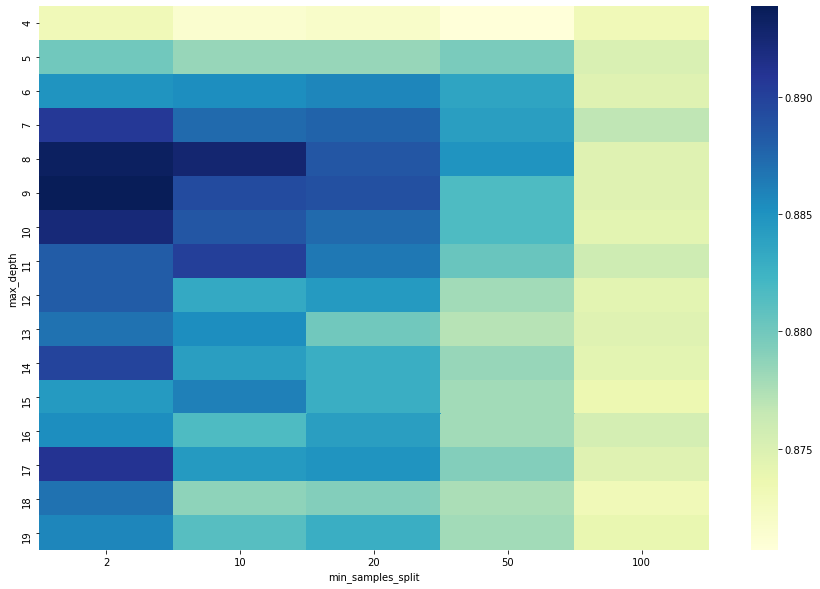

In [230]:
#Vamos a visualizar un heatmap con los valores de gridsearch
hmap_dt = pd.pivot_table(df_gs_dt, values='Accuracy', 
                     index=['max_depth'], 
                     columns='min_samples_split')
plt.subplots(figsize=(15,10))
sns.heatmap(hmap_dt,cmap="YlGnBu")

In [231]:
#Probamos el poder predictor del clasificador hallado (best_estimator_) en el conjunto de test
y_pred_dt = gscv_dt_result.best_estimator_.predict(X_test_gs)

print("Accuracy:",metrics.accuracy_score(y_test_gs, y_pred_dt))

Accuracy: 0.9057471264367816


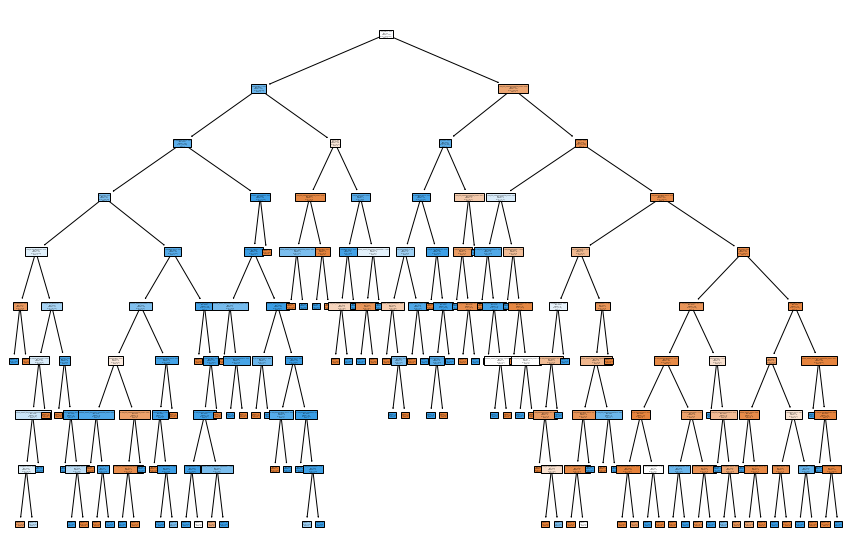

In [232]:
#Representamos el arbol de decisión resultante del mejor predictor
features_list=list(df_dam_feat.columns)
fig = plt.figure(figsize=(15,10))
_=tree.plot_tree((gscv_dt_result.best_estimator_),feature_names=features_list,class_names=['0','1'],
                   filled=True)

In [234]:
#La matriz de confusion quedaría
confusion_matrix(y_test_gs, y_pred_dt)

array([[190,  20],
       [ 21, 204]])

Accuracy: 0.9


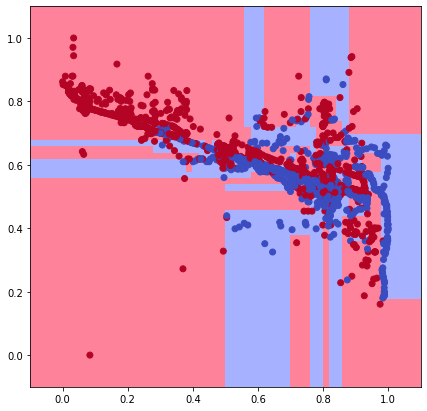

In [235]:
#Hallamos un predictor usando únicamente las variables "Salinidad_guadalhorce" y "Cota_guadalhorce" para visualizar
#las fronteras de decisión de estas dos variables al clasificar "Salinidad_mezcla"
#A continuación vamos a crear y a entrenar un nuevo DecisionTreeClassifier
clf_dt_bound=tree.DecisionTreeClassifier()

#Entrenamos el árbol de decisión
clf_dt_bound=clf_dt_bound.fit(X_train_bound,y_train_bound)

#Y mostramos la precisión del clasificador hallado
y_pred = clf_dt_bound.predict(X_test_bound)
print("Accuracy:",metrics.accuracy_score(y_test_bound, y_pred))

#Mostramos las fronteras decisión cuando seleccionamos las variables "Salinidad_guadalhorce" y "Cota_guadalhorce"
plot_decision_boundaries(X_train_bound['Cota_guadalhorce'], X_train_bound['Salinidad_guadalhorce'],y_train_bound,clf_dt_bound)

## 5.2 Random Forest

In [388]:
#Construimos el vector de hiperparámetros
m_depth_rf=list(range(6,20))
num_est=[10,50,100,200]
param_grid_rf= dict(max_depth=m_depth_rf, n_estimators=num_est)
param_grid_rf

#A la función GridSearchCV le pasamos el estimador y el vector de hiperparámetros. Además fijamos el parámetro
#de cross-validation a 5, así el conjunto de validación será un 17% y el conjunto de entrenamiento un 68%. 
#Ya que deseamos medir la precisión del modelo, se lo indicamos a través de scoring='accuracy'. 
#Por último, se usa n_jobs=-1 para ejecutar los procesos en paralelo.
gscv_rf=GridSearchCV(RandomForestClassifier(),param_grid_rf, cv=5, n_jobs=-1,scoring='accuracy')

#Se entrena el clasificador
gscv_result_rf=gscv_rf.fit(X_train_gs,y_train_gs)

#Se imprimen los mejores hiperparámetros
print(gscv_result_rf.best_score_)
print(gscv_result_rf.best_params_)

0.9324938320666302
{'max_depth': 16, 'n_estimators': 100}


In [389]:
#Construimos el dataframe con el que se contruirá el heatmap
sc_rf=gscv_result_rf.cv_results_['mean_test_score']
param_rf=gscv_result_rf.cv_results_['params']
gscv_result_rf.cv_results_
aux1_rf=pd.DataFrame(param_rf)
aux2_rf=pd.DataFrame({'Accuracy':sc_rf})
df_gs_rf=pd.concat([aux1_rf,aux2_rf],axis=1)
df_gs_rf

,max_depth,n_estimators,Accuracy
0,6,10,0.894678
1,6,50,0.902401
2,6,100,0.905246
3,6,200,0.905246
4,7,10,0.906062
5,7,50,0.910942
6,7,100,0.914601
7,7,200,0.911753
8,8,10,0.912164
9,8,50,0.914601


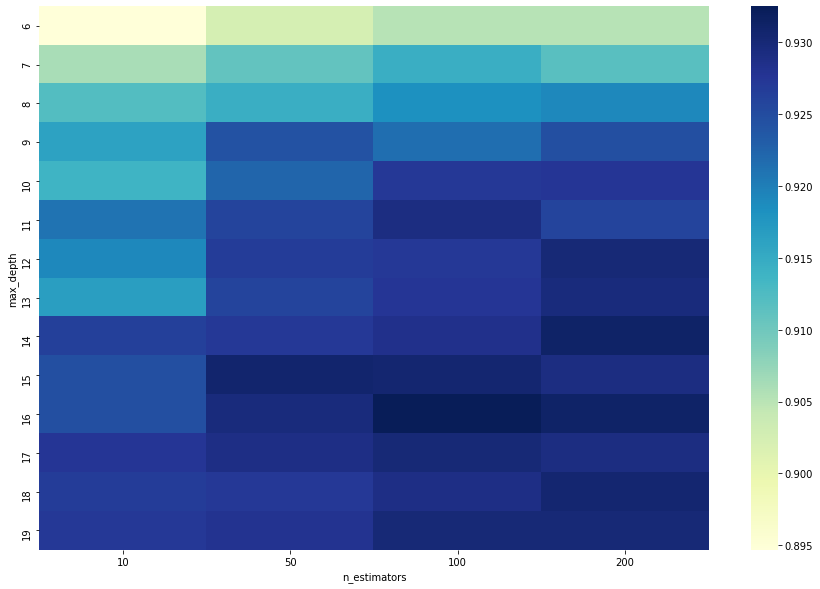

In [390]:
#Se imprime el heatmap
hmap_rf = pd.pivot_table(df_gs_rf, values='Accuracy', 
                     index=['max_depth'], 
                     columns='n_estimators')
plt.subplots(figsize=(15,10))
sns.heatmap(hmap_rf,cmap="YlGnBu")

In [391]:
#Probamos el poder predictor del clasificador hallado (best_estimator_)
y_pred_rf = gscv_result_rf.best_estimator_.predict(X_test_gs)

print("Accuracy:",metrics.accuracy_score(y_test_gs, y_pred_rf))

Accuracy: 0.9448275862068966


In [392]:
#La matriz de confusion quedaría
confusion_matrix(y_test_gs, y_pred_rf)

array([[198,  12],
       [ 12, 213]])

Accuracy: 0.896551724137931


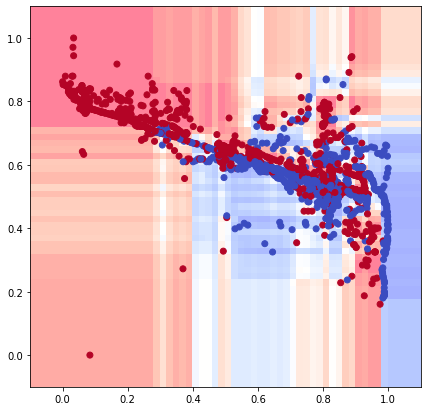

In [393]:
#Hallamos un predictor usando únicamente las variables "Salinidad_guadalhorce" y "Cota_guadalhorce" para visualizar
#las fronteras de decisión de estas dos variables al clasificar "Salinidad_mezcla"
clf_rf_bound=RandomForestClassifier(max_depth=14, n_estimators=50)

#Entrenamos el bosque de decisión
clf_rf_bound=clf_rf_bound.fit(X_train_bound,y_train_bound)

#Y mostramos la precisión del clasificador hallado
y_pred_rf = clf_rf_bound.predict(X_test_bound)
print("Accuracy:",metrics.accuracy_score(y_test_bound, y_pred_rf))

#Mostramos las fronteras decisión cuando seleccionamos las variables "Salinidad_guadalhorce" y "Cota_guadalhorce"
plot_decision_boundaries(X_train_bound['Cota_guadalhorce'], X_train_bound['Salinidad_guadalhorce'],y_train_bound,clf_rf_bound)

## 5.3 Maquinas de Soporte Vectorial (SVM) 

In [ ]:
#Creamos los vectores de hiperparámetros que se usará en GridSearch
v_C=[0.01,0.1,1,10,50,100,200]
v_gamma=[0.001,0.01,0.1,1,10]
param_grid_svc= dict(C=v_C, gamma=v_gamma, kernel=['rbf'])

#A la función GridSearchCV le pasamos el estimador y el vector de hiperparámetros. Además fijamos el parámetro
#de cross-validation a 5, así el conjunto de validación será un 17% y el conjunto de entrenamiento un 68%. 
#Ya que deseamos medir la precisión del modelo, se lo indicamos a través de scoring='accuracy'. 
#Por último, se usa n_jobs=-1 para ejecutar los procesos en paralelo.
gscv_svc=GridSearchCV(SVC(),param_grid_svc, cv=5, n_jobs=-1,scoring='accuracy')

#Se entrena el clasificador
gscv_result_svc=gscv_svc.fit(X_train_gs,y_train_gs)

print(gscv_result_svc.best_score_)
print(gscv_result_svc.best_params_)

In [209]:
#Construimos el dataframe con el que se contruirá el heatmap
sc_svc=gscv_result_svc.cv_results_['mean_test_score']
param_svc=gscv_result_svc.cv_results_['params']
gscv_result_svc.cv_results_
aux1_svc=pd.DataFrame(param_svc)
aux2_svc=pd.DataFrame({'Accuracy':sc_svc})
df_gs_svc=pd.concat([aux1_svc,aux2_svc],axis=1)
df_gs_svc

,C,gamma,kernel,Accuracy
0,0.01,0.001,rbf,0.503863
1,0.01,0.010,rbf,0.503863
2,0.01,0.100,rbf,0.793835
3,0.01,1.000,rbf,0.824730
4,0.01,10.000,rbf,0.503863
5,0.10,0.001,rbf,0.503863
6,0.10,0.010,rbf,0.777971
7,0.10,0.100,rbf,0.826763
8,0.10,1.000,rbf,0.861741
9,0.10,10.000,rbf,0.882071


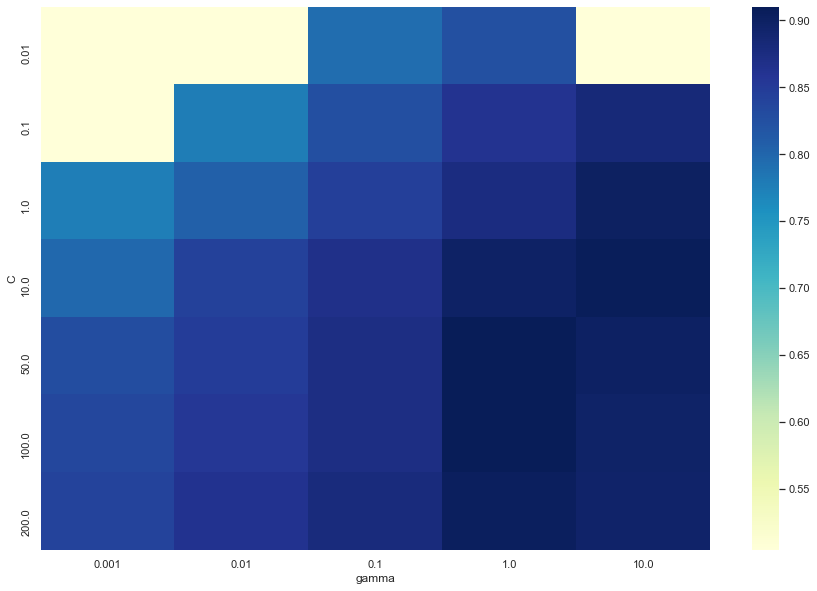

In [210]:
#Se imprime el heatmap
hmap_svc = pd.pivot_table(df_gs_svc, values='Accuracy', 
                     index=['C'], 
                     columns='gamma')
plt.subplots(figsize=(15,10))
sns.heatmap(hmap_svc,cmap="YlGnBu")

In [211]:
#Probamos el poder predictor del clasificador hallado (best_estimator_)
y_pred_svc = gscv_result_svc.best_estimator_.predict(X_test_gs)

print("Accuracy:",metrics.accuracy_score(y_test_gs, y_pred_svc))

Accuracy: 0.9310344827586207


In [212]:
#La matriz de confusion quedaría
confusion_matrix(y_test_gs, y_pred_svc)

array([[195,  15],
       [ 15, 210]])

Accuracy: 0.6896551724137931


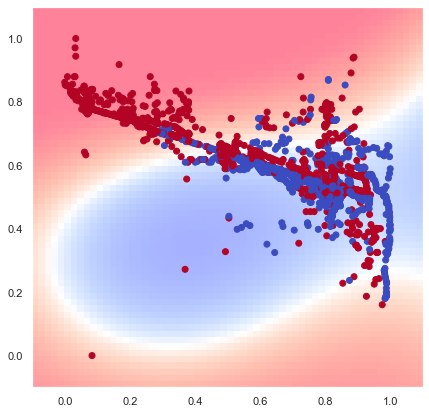

In [213]:
#Hallamos un predictor usando únicamente las variables "Salinidad_guadalhorce" y "Cota_guadalhorce" para visualizar
#las fronteras de decisión de estas dos variables al clasificar "Salinidad_mezcla"
clf_svc_bound=SVC(C=10,gamma=1,kernel='rbf', probability=True)

#Entrenamos el árbol de decisión
clf_svc_bound=clf_svc_bound.fit(X_train_bound,y_train_bound)

#Y mostramos la precisión del clasificador hallado
y_pred_svc = clf_svc_bound.predict(X_test_bound)
print("Accuracy:",metrics.accuracy_score(y_test_bound, y_pred_svc))

#Mostramos las fronteras decisión cuando seleccionamos las variables "Salinidad_guadalhorce" y "Cota_guadalhorce"
plot_decision_boundaries(X_train_bound['Cota_guadalhorce'], X_train_bound['Salinidad_guadalhorce'],y_train_bound,clf_svc_bound)

### 2.4 AdaBoost 

In [214]:
#Construimos el vector de hiperparámetros
l_rate=[0.01,0.1,1,2]
n_estimators_boost=[10,50,100,200]
param_grid_ab= dict( learning_rate=l_rate,n_estimators=n_estimators_boost)

#A la función GridSearchCV le pasamos el estimador y el vector de hiperparámetros. Además fijamos el parámetro
#de cross-validation a 5, así el conjunto de validación será un 17% y el conjunto de entrenamiento un 68%. 
#Ya que deseamos medir la precisión del modelo, se lo indicamos a través de scoring='accuracy'. 
#Por último, se usa n_jobs=-1 para ejecutar los procesos en paralelo.
gscv_ab=GridSearchCV(AdaBoostClassifier(),param_grid_ab, cv=5, n_jobs=-1,scoring='accuracy')

#Al igual que en el caso anterior, usamos X e y, en lugar de X_train e y_train ya que usando cross-validation 
#nos aseguramos que el algoritmo separa el el conjunto de datos en 4 subconjuntos, eligiendo en cada iteracion 
#un subconjunto para el train set [1].
gscv_result_ab=gscv_ab.fit(X_train_gs,y_train_gs)

print(gscv_result_ab.best_score_)
print(gscv_result_ab.best_params_)

0.9141920421240872
{'learning_rate': 1, 'n_estimators': 200}


In [215]:
#Construimos el dataframe con el que se contruirá el heatmap
sc_ab=gscv_result_ab.cv_results_['mean_test_score']
param_ab=gscv_result_ab.cv_results_['params']
gscv_result_ab.cv_results_
aux1_ab=pd.DataFrame(param_ab)
aux2_ab=pd.DataFrame({'Accuracy':sc_ab})
df_gs_ab=pd.concat([aux1_ab,aux2_ab],axis=1)
df_gs_ab

,learning_rate,n_estimators,Accuracy
0,0.01,10,0.789342
1,0.01,50,0.797472
2,0.01,100,0.843837
3,0.01,200,0.844650
4,0.10,10,0.843430
5,0.10,50,0.857668
6,0.10,100,0.869056
7,0.10,200,0.884099
8,1.00,10,0.858894
9,1.00,50,0.885732


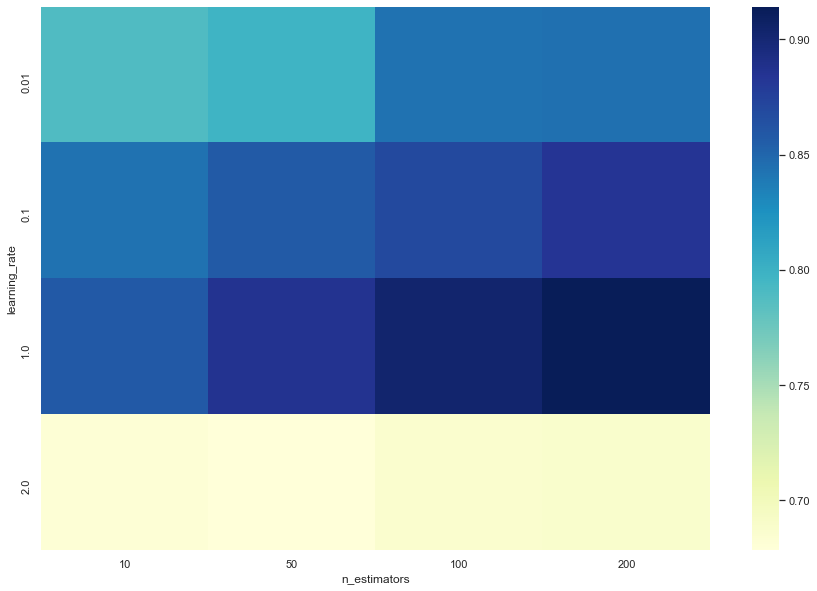

In [216]:
hmap_ab = pd.pivot_table(df_gs_ab, values='Accuracy', 
                     index=['learning_rate'], 
                     columns='n_estimators')
plt.subplots(figsize=(15,10))
sns.heatmap(hmap_ab,cmap="YlGnBu")

In [217]:
#Probamos el poder predictor del clasificador hallado (best_estimator_)
y_pred_ab = gscv_result_ab.best_estimator_.predict(X_test_gs)

print("Accuracy:",metrics.accuracy_score(y_test_gs, y_pred_ab))

Accuracy: 0.9310344827586207


In [218]:
#La matriz de confusion quedaría
confusion_matrix(y_test_gs, y_pred_ab)

array([[195,  15],
       [ 15, 210]])

Accuracy: 0.8413793103448276


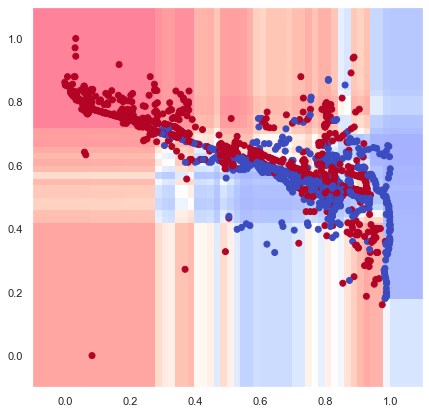

In [219]:
#Hallamos un predictor usando únicamente las variables "Salinidad_guadalhorce" y "Cota_guadalhorce"
#A continuación vamos a crear y a entrenar un nuevo DecisionTreeClassifier
clf_ab_bound=GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)

#Entrenamos el árbol de decisión
clf_ab_bound=clf_ab_bound.fit(X_train_bound,y_train_bound)

#Y mostramos la precisión del clasificador hallado
y_pred_ab = clf_ab_bound.predict(X_test_bound)
print("Accuracy:",metrics.accuracy_score(y_test_bound, y_pred_ab))

#Mostramos las fronteras decisión cuando seleccionamos las variables "Salinidad_guadalhorce" y "Cota_guadalhorce"
plot_decision_boundaries(X_train_bound['Cota_guadalhorce'], X_train_bound['Salinidad_guadalhorce'],y_train_bound,clf_ab_bound)

# 6. Análisis de los resultados

Se muestra la precisión de clasificación de la variable Salinidad_mezcla hallada para cada método de aprendizaje automático, en los conjuntos de entrenamiento y validación, y para cada método de imputación de missing values. 

In [220]:
ml_methods=["Imputation Method","Decision Trees", "Random Forest","Support Vector Machine", "AdaBoost","ANN"]
imputation_methods=['Drop NAN','Mean','Median','Rolling Mean','Rolling Median','Linear Interpolation','Quadratic Interpolation',
                   'Cubic Interpolation','Akima Interpolation','Spline Interpolation','Linear Regressor Predictor']
                   
result_mean=[87.26,89.46,87.26,87.96,85.26]
result_median=[88.57,90.48,88.49,90.52]
result_rolling_mean=[90.09,92.87,88.96,91.65]
result_rolli_median=[88.91,92.56,89.74,91.74],
result_inter_linear=[90.89,94.02,91.17,93.04]
result_inter_quadratic=[89.96,92.13,88.77,90.86]
result_inter_cubic=[89.80,92.50,88.00,90.99]
result_inter_akima=[90.78,93.93,91.03,93.28]
#result_inter_pol_3=[89.92,92.50,88.00,90.86]
result_inter_spline=[89.14,92.31,87.31,90.03]

result_desicion_trees=['87.26','88.32','88.36','89.74','89.52','91.21','89.14','89.06','91.27','89.83','87.63']
result_random_forest=['89.46','88.97','90.36','92.56','92.82','93.94','91.89','92.05','93.85','92.15','89.79']
result_svm=['87.26','88.16','88.45','88.61','89.61','91.01','88.73','88.12','90.62','87.18','88.32']
result_ada_boost=['87.96','86.82','88.53','90.04','89.43','91.37','88.61','89.06','91.11','88.04','88.45']
result_ann=['85.26','86.21','87.83','83.70','83.00','86.66','82.75','82.30','85.87','81.61','86.41']

df_result=pd.DataFrame(list(zip(imputation_methods,result_desicion_trees,result_random_forest,result_svm,result_ada_boost,result_ann))
                       ,columns=ml_methods)

df_result

,Imputation Method,Decision Trees,Random Forest,Support Vector Machine,AdaBoost,ANN
0,Drop NAN,87.26,89.46,87.26,87.96,85.26
1,Mean,88.32,88.97,88.16,86.82,86.21
2,Median,88.36,90.36,88.45,88.53,87.83
3,Rolling Mean,89.74,92.56,88.61,90.04,83.70
4,Rolling Median,89.52,92.82,89.61,89.43,83.00
5,Linear Interpolation,91.21,93.94,91.01,91.37,86.66
6,Quadratic Interpolation,89.14,91.89,88.73,88.61,82.75
7,Cubic Interpolation,89.06,92.05,88.12,89.06,82.30
8,Akima Interpolation,91.27,93.85,90.62,91.11,85.87
9,Spline Interpolation,89.83,92.15,87.18,88.04,81.61


In [221]:
result_test_desicion_trees=['84.18','86.89','84.82','89.68','89.92','93.33','89.32','88.63','90.95','89.88','88.96']
result_test_random_forest=['88.70','87.81','90.11','92.13','94.10','95.63','92.80','93.50','94.89','93.33','90.57']
result_test_svm=['85.31','86.66','88.96','87.96','89.92','93.10','87.47','88.16','89.32','87.81','87.12']
result_test_ada_boost=['89.26','86.43','87.81','88.20','87.96','93.10','90.48','89.55','92.11','88.96','88.50']
result_test_ann=['81.35','85.51','87.81','82.55','80.83','87.58','85.38','84.91','87.00','84.13','86.20']

df_test_result=pd.DataFrame(list(zip(imputation_methods,result_test_desicion_trees,result_test_random_forest,result_test_svm,result_test_ada_boost,result_test_ann))
                       ,columns=ml_methods)

df_test_result

,Imputation Method,Decision Trees,Random Forest,Support Vector Machine,AdaBoost,ANN
0,Drop NAN,84.18,88.70,85.31,89.26,81.35
1,Mean,86.89,87.81,86.66,86.43,85.51
2,Median,84.82,90.11,88.96,87.81,87.81
3,Rolling Mean,89.68,92.13,87.96,88.20,82.55
4,Rolling Median,89.92,94.10,89.92,87.96,80.83
5,Linear Interpolation,93.33,95.63,93.10,93.10,87.58
6,Quadratic Interpolation,89.32,92.80,87.47,90.48,85.38
7,Cubic Interpolation,88.63,93.50,88.16,89.55,84.91
8,Akima Interpolation,90.95,94.89,89.32,92.11,87.00
9,Spline Interpolation,89.88,93.33,87.81,88.96,84.13


## 6.4. Visualizaciones

### 6.4.1 Predicción de Salinidad_mezcla en función de otras variables

A continuación se creará un dataframe en el que solo variará los valores de la variable "Salinidad_guadalhorce" y 
el resto de variables permanecerá constante. Este dataframe servirá como entrada al predictor con más capacidad 
predictiva hallado anteriormente con el objetivo de analizar la clasificación de la variable "Salinidad_mezcla" en
función de la variación de "Salinidad_guadalhorce".

Text(0, 0.5, 'Predicción de la salinidad de la mezcla')

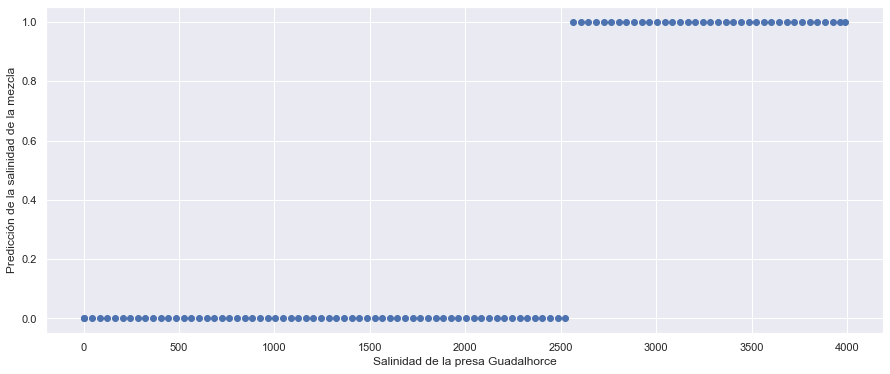

In [339]:
#Predicción de la Salinidad_mezcla en función de Salinidad_guadalhorce

#Extraemos los valores máximos y mínimos de la variable "Salinidad_guadalhorce" y elegimos 102 elementos para evaluar
#el predictor. Estos elementos se normalizan ya que el predictor está optimizado para valores normalizados.
max_val=[max(df_dam_x["Salinidad_guadalhorce"])]
max_val=pd.DataFrame(max_val)
min_val=[min(df_dam_x["Salinidad_guadalhorce"])]
min_val=pd.DataFrame(min_val)
v_salt=range(4,3991,40)
v_salt=pd.DataFrame(v_salt)
v_salt=pd.concat([min_val, v_salt]).reset_index(drop = True) 
v_salt=v_salt.append(max_val,ignore_index=True)
v_salt=v_salt.rename(columns={0:"Salinidad_guadalhorce"})
scaler=MinMaxScaler()
v_salt_norm=scaler.fit_transform(v_salt)
v_salt_norm=pd.DataFrame(v_salt_norm,columns=["Salinidad_guadalhorce"])

#Elegimos la mediana de cada variable resultante del proceso de reducción de dimensionalidad
column_names=["Caudal_riego","Volumen_riego","Volumen_evaporado_guadalteba","Cota_guadalhorce","Cota_guadalteba",
             "Volumen_embalsado_guadalhorce","Salinidad_guadalhorce","Volumen_total_guadalhorce_guadalteba",
             "Temperatura_Max","Volumen_embalsado_guadalteba","Volumen_total_guadalhorce_guadalteba_conde",
             "Evaporacion","Temperatura_Min","Volumen_total_demandas","Caudal_total_demandas",
             "Total_volumen_abastecido","Cota_conde","Volumen_desembalse_guadalteba","Volumen_embalsado_conde",
             "Anyo"]
v_1=df_dam_feat["Caudal_riego"].median()
v_2=df_dam_feat["Volumen_riego"].median()
v_3=df_dam_feat["Volumen_evaporado_guadalteba"].median()
v_4=df_dam_feat["Cota_guadalhorce"].median()
v_5=df_dam_feat["Cota_guadalteba"].median()
v_6=df_dam_feat["Volumen_embalsado_guadalhorce"].median()
v_7=df_dam_feat["Volumen_total_guadalhorce_guadalteba"].median()
v_8=df_dam_feat["Temperatura_Max"].median()
v_9=df_dam_feat["Volumen_embalsado_guadalteba"].median()
v_10=df_dam_feat["Volumen_total_guadalhorce_guadalteba_conde"].median()
v_11=df_dam_feat["Evaporacion"].median()
v_12=df_dam_feat["Temperatura_Min"].median()
v_13=df_dam_feat["Volumen_total_demandas"].median()
v_14=df_dam_feat["Caudal_total_demandas"].median()
v_15=df_dam_feat["Total_volumen_abastecido"].median()
v_16=df_dam_feat["Cota_conde"].median()
v_17=df_dam_feat["Volumen_desembalse_guadalteba"].median()
v_18=df_dam_feat["Volumen_embalsado_conde"].median()
v_19=df_dam_feat["Anyo"].median()

v_1=np.full(shape=102,fill_value=v_1)
v_1=pd.DataFrame(v_1)
v_2=np.full(shape=102,fill_value=v_2)
v_2=pd.DataFrame(v_2)
v_3=np.full(shape=102,fill_value=v_3)
v_3=pd.DataFrame(v_3)
v_4=np.full(shape=102,fill_value=v_4)
v_4=pd.DataFrame(v_4)
v_5=np.full(shape=102,fill_value=v_5)
v_5=pd.DataFrame(v_5)
v_6=np.full(shape=102,fill_value=v_6)
v_6=pd.DataFrame(v_6)
v_7=np.full(shape=102,fill_value=v_7)
v_7=pd.DataFrame(v_7)
v_8=np.full(shape=102,fill_value=v_8)
v_8=pd.DataFrame(v_8)
v_9=np.full(shape=102,fill_value=v_9)
v_9=pd.DataFrame(v_9)
v_10=np.full(shape=102,fill_value=v_10)
v_10=pd.DataFrame(v_10)
v_11=np.full(shape=102,fill_value=v_11)
v_11=pd.DataFrame(v_11)
v_12=np.full(shape=102,fill_value=v_12)
v_12=pd.DataFrame(v_12)
v_13=np.full(shape=102,fill_value=v_13)
v_13=pd.DataFrame(v_13)
v_14=np.full(shape=102,fill_value=v_14)
v_14=pd.DataFrame(v_14)
v_15=np.full(shape=102,fill_value=v_15)
v_15=pd.DataFrame(v_15)
v_16=np.full(shape=102,fill_value=v_16)
v_16=pd.DataFrame(v_16)
v_17=np.full(shape=102,fill_value=v_17)
v_17=pd.DataFrame(v_17)
v_18=np.full(shape=102,fill_value=v_18)
v_18=pd.DataFrame(v_18)
v_19=np.full(shape=102,fill_value=v_19)
v_19=pd.DataFrame(v_19)
df_salt_eval=pd.concat([v_1,v_2,v_3,v_4,v_5,v_6,v_salt_norm,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,v_15,v_16,v_17,v_18
                    ,v_19],axis=1)
df_salt_eval.columns=column_names

#Usamos el mejor predictor sobre el dataframe creado

#Deshacemos la normalización en la variable "Salinidad_guadalhorce" para ver la clasificación de "Salinidad_mezcla"
#en función de los valores reales de "Salinidad_guadalhorce"
salt_ghorce_eval=scaler.inverse_transform(v_salt_norm)
result_eval=gscv_result_rf.best_estimator_.predict(df_salt_eval)
fig = plt.figure(figsize=(15,6))
plt.scatter(salt_ghorce_eval,result_eval)
plt.xlabel("Salinidad de la presa Guadalhorce")
plt.ylabel("Predicción de la salinidad de la mezcla")

Text(0, 0.5, 'Predicción de la salinidad de la mezcla')

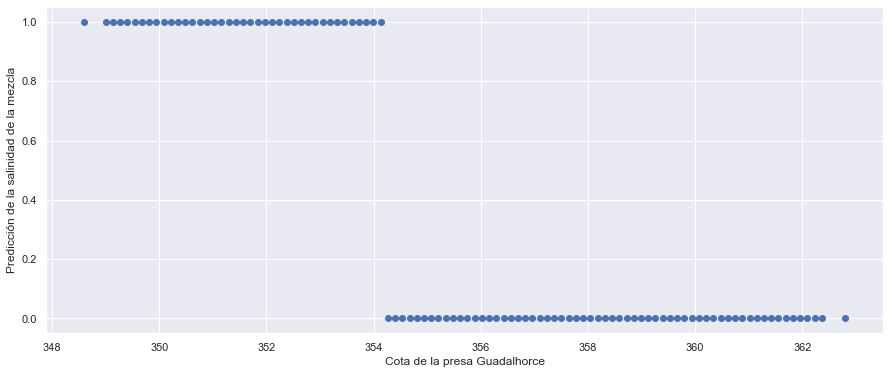

In [370]:
#Predicción de la Salinidad_mezcla en función de Cota_guadalhorce

#Extraemos los valores máximos y mínimos de la variable "Cota_guadalhorce" y elegimos 102 elementos para evaluar
#el predictor. Estos elementos se normalizan ya que el predictor está optimizado para valores normalizados.
max_val_level=[max(df_dam_x["Cota_guadalhorce"])]
max_val_level=pd.DataFrame(max_val_level)
min_val_level=[min(df_dam_x["Cota_guadalhorce"])]
min_val_level=pd.DataFrame(min_val_level)
v_salt_level=np.arange(349, 362.5, 0.135)
v_salt_level=pd.DataFrame(v_salt_level)
v_salt_level=pd.concat([min_val_level, v_salt_level]).reset_index(drop = True) 
v_salt_level=v_salt_level.append(max_val_level,ignore_index=True)
v_salt_level=v_salt_level.rename(columns={0:"Cota_guadalhorce"})
scaler=MinMaxScaler()
v_salt_level_norm=scaler.fit_transform(v_salt_level)
v_salt_level_norm=pd.DataFrame(v_salt_level_norm,columns=["Cota_guadalhorce"])


v_1=df_dam_feat["Caudal_riego"].median()
v_2=df_dam_feat["Volumen_riego"].median()
v_3=df_dam_feat["Volumen_evaporado_guadalteba"].median()
v_4=df_dam_feat["Salinidad_guadalhorce"].median()
v_5=df_dam_feat["Cota_guadalteba"].median()
v_6=df_dam_feat["Volumen_embalsado_guadalhorce"].median()
v_7=df_dam_feat["Volumen_total_guadalhorce_guadalteba"].median()
v_8=df_dam_feat["Temperatura_Max"].median()
v_9=df_dam_feat["Volumen_embalsado_guadalteba"].median()
v_10=df_dam_feat["Volumen_total_guadalhorce_guadalteba_conde"].median()
v_11=df_dam_feat["Evaporacion"].median()
v_12=df_dam_feat["Temperatura_Min"].median()
v_13=df_dam_feat["Volumen_total_demandas"].median()
v_14=df_dam_feat["Caudal_total_demandas"].median()
v_15=df_dam_feat["Total_volumen_abastecido"].median()
v_16=df_dam_feat["Cota_conde"].median()
v_17=df_dam_feat["Volumen_desembalse_guadalteba"].median()
v_18=df_dam_feat["Volumen_embalsado_conde"].median()
v_19=df_dam_feat["Anyo"].median()

v_1=np.full(shape=102,fill_value=v_1)
v_1=pd.DataFrame(v_1)
v_2=np.full(shape=102,fill_value=v_2)
v_2=pd.DataFrame(v_2)
v_3=np.full(shape=102,fill_value=v_3)
v_3=pd.DataFrame(v_3)
v_4=np.full(shape=102,fill_value=v_4)
v_4=pd.DataFrame(v_4)
v_5=np.full(shape=102,fill_value=v_5)
v_5=pd.DataFrame(v_5)
v_6=np.full(shape=102,fill_value=v_6)
v_6=pd.DataFrame(v_6)
v_7=np.full(shape=102,fill_value=v_7)
v_7=pd.DataFrame(v_7)
v_8=np.full(shape=102,fill_value=v_8)
v_8=pd.DataFrame(v_8)
v_9=np.full(shape=102,fill_value=v_9)
v_9=pd.DataFrame(v_9)
v_10=np.full(shape=102,fill_value=v_10)
v_10=pd.DataFrame(v_10)
v_11=np.full(shape=102,fill_value=v_11)
v_11=pd.DataFrame(v_11)
v_12=np.full(shape=102,fill_value=v_12)
v_12=pd.DataFrame(v_12)
v_13=np.full(shape=102,fill_value=v_13)
v_13=pd.DataFrame(v_13)
v_14=np.full(shape=102,fill_value=v_14)
v_14=pd.DataFrame(v_14)
v_15=np.full(shape=102,fill_value=v_15)
v_15=pd.DataFrame(v_15)
v_16=np.full(shape=102,fill_value=v_16)
v_16=pd.DataFrame(v_16)
v_17=np.full(shape=102,fill_value=v_17)
v_17=pd.DataFrame(v_17)
v_18=np.full(shape=102,fill_value=v_18)
v_18=pd.DataFrame(v_18)
v_19=np.full(shape=102,fill_value=v_19)
v_19=pd.DataFrame(v_19)
df_level_eval=pd.concat([v_1,v_2,v_3,v_salt_level_norm,v_5,v_6,v_4,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,v_15,v_16,v_17,v_18
                    ,v_19],axis=1)
df_level_eval.columns=column_names

#Usamos el mejor predictor sobre el dataframe creado

#Deshacemos la normalización en la variable "Cota_guadalhorce" para ver la clasificación de "Salinidad_mezcla"
#en función de los valores reales de "Cota_guadalhorce"
level_ghorce_eval=scaler.inverse_transform(v_salt_level_norm)
result_eval_level=gscv_result_rf.best_estimator_.predict(df_level_eval)
fig = plt.figure(figsize=(15,6))
plt.scatter(level_ghorce_eval,result_eval_level)
plt.xlabel("Cota de la presa Guadalhorce")
plt.ylabel("Predicción de la salinidad de la mezcla")

Text(0, 0.5, 'Predicción de la salinidad de la mezcla')

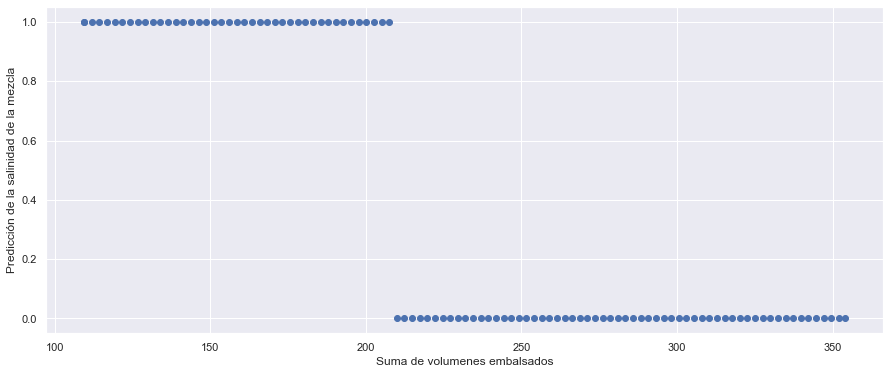

In [382]:
#Predicción de la Salinidad_mezcla en función de Volumen_total_guadalhorce_guadalteba_conde

#Extraemos los valores máximos y mínimos de la variable "Volumen_total_guadalhorce_guadalteba_conde" y elegimos 102 elementos para evaluar
#el predictor. Estos elementos se normalizan ya que el predictor está optimizado para valores normalizados.
max_val_vol=[max(df_dam_x["Volumen_total_guadalhorce_guadalteba_conde"])]
max_val_vol=pd.DataFrame(max_val_vol)
min_val_vol=[min(df_dam_x["Volumen_total_guadalhorce_guadalteba_conde"])]
min_val_vol=pd.DataFrame(min_val_vol)
v_salt_vol=np.arange(109.497, 354.046, 2.45)
v_salt_vol=pd.DataFrame(v_salt_vol)
v_salt_vol=pd.concat([min_val_vol, v_salt_vol]).reset_index(drop = True) 
v_salt_vol=v_salt_vol.append(max_val_vol,ignore_index=True)
v_salt_vol=v_salt_vol.rename(columns={0:"Volumen_total_guadalhorce_guadalteba_conde"})
scaler=MinMaxScaler()
v_salt_vol_norm=scaler.fit_transform(v_salt_vol)
v_salt_vol_norm=pd.DataFrame(v_salt_vol_norm,columns=["Volumen_total_guadalhorce_guadalteba_conde"])


v_1=df_dam_feat["Caudal_riego"].median()
v_2=df_dam_feat["Volumen_riego"].median()
v_3=df_dam_feat["Volumen_evaporado_guadalteba"].median()
v_4=df_dam_feat["Salinidad_guadalhorce"].median()
v_5=df_dam_feat["Cota_guadalteba"].median()
v_6=df_dam_feat["Volumen_embalsado_guadalhorce"].median()
v_7=df_dam_feat["Volumen_total_guadalhorce_guadalteba"].median()
v_8=df_dam_feat["Temperatura_Max"].median()
v_9=df_dam_feat["Volumen_embalsado_guadalteba"].median()
v_10=df_dam_feat["Cota_guadalhorce"].median()
v_11=df_dam_feat["Evaporacion"].median()
v_12=df_dam_feat["Temperatura_Min"].median()
v_13=df_dam_feat["Volumen_total_demandas"].median()
v_14=df_dam_feat["Caudal_total_demandas"].median()
v_15=df_dam_feat["Total_volumen_abastecido"].median()
v_16=df_dam_feat["Cota_conde"].median()
v_17=df_dam_feat["Volumen_desembalse_guadalteba"].median()
v_18=df_dam_feat["Volumen_embalsado_conde"].median()
v_19=df_dam_feat["Anyo"].median()

v_1=np.full(shape=102,fill_value=v_1)
v_1=pd.DataFrame(v_1)
v_2=np.full(shape=102,fill_value=v_2)
v_2=pd.DataFrame(v_2)
v_3=np.full(shape=102,fill_value=v_3)
v_3=pd.DataFrame(v_3)
v_4=np.full(shape=102,fill_value=v_4)
v_4=pd.DataFrame(v_4)
v_5=np.full(shape=102,fill_value=v_5)
v_5=pd.DataFrame(v_5)
v_6=np.full(shape=102,fill_value=v_6)
v_6=pd.DataFrame(v_6)
v_7=np.full(shape=102,fill_value=v_7)
v_7=pd.DataFrame(v_7)
v_8=np.full(shape=102,fill_value=v_8)
v_8=pd.DataFrame(v_8)
v_9=np.full(shape=102,fill_value=v_9)
v_9=pd.DataFrame(v_9)
v_10=np.full(shape=102,fill_value=v_10)
v_10=pd.DataFrame(v_10)
v_11=np.full(shape=102,fill_value=v_11)
v_11=pd.DataFrame(v_11)
v_12=np.full(shape=102,fill_value=v_12)
v_12=pd.DataFrame(v_12)
v_13=np.full(shape=102,fill_value=v_13)
v_13=pd.DataFrame(v_13)
v_14=np.full(shape=102,fill_value=v_14)
v_14=pd.DataFrame(v_14)
v_15=np.full(shape=102,fill_value=v_15)
v_15=pd.DataFrame(v_15)
v_16=np.full(shape=102,fill_value=v_16)
v_16=pd.DataFrame(v_16)
v_17=np.full(shape=102,fill_value=v_17)
v_17=pd.DataFrame(v_17)
v_18=np.full(shape=102,fill_value=v_18)
v_18=pd.DataFrame(v_18)
v_19=np.full(shape=102,fill_value=v_19)
v_19=pd.DataFrame(v_19)
df_vol_eval=pd.concat([v_1,v_2,v_3,v_10,v_5,v_6,v_4,v_7,v_8,v_9,v_salt_vol_norm,v_11,v_12,v_13,v_14,v_15,v_16,v_17,v_18
                    ,v_19],axis=1)
df_vol_eval.columns=column_names

column_names=["Caudal_riego","Volumen_riego","Volumen_evaporado_guadalteba","Cota_guadalhorce","Cota_guadalteba",
             "Volumen_embalsado_guadalhorce","Salinidad_guadalhorce","Volumen_total_guadalhorce_guadalteba",
             "Temperatura_Max","Volumen_embalsado_guadalteba","Volumen_total_guadalhorce_guadalteba_conde",
             "Evaporacion","Temperatura_Min","Volumen_total_demandas","Caudal_total_demandas",
             "Total_volumen_abastecido","Cota_conde","Volumen_desembalse_guadalteba","Volumen_embalsado_conde",
             "Anyo"]


#Usamos el mejor predictor sobre el dataframe creado

#Deshacemos la normalización en la variable "Volumen_total_guadalhorce_guadalteba_conde" para ver la clasificación de "Salinidad_mezcla"
#en función de los valores reales de "Volumen_total_guadalhorce_guadalteba_conde"
vol_eval=scaler.inverse_transform(v_salt_vol_norm)
result_eval_vol=gscv_result_rf.best_estimator_.predict(df_vol_eval)
fig = plt.figure(figsize=(15,6))
plt.scatter(vol_eval,result_eval_vol)
plt.xlabel("Suma de volumenes embalsados")
plt.ylabel("Predicción de la salinidad de la mezcla")

Text(0, 0.5, 'Predicción de la salinidad de la mezcla')

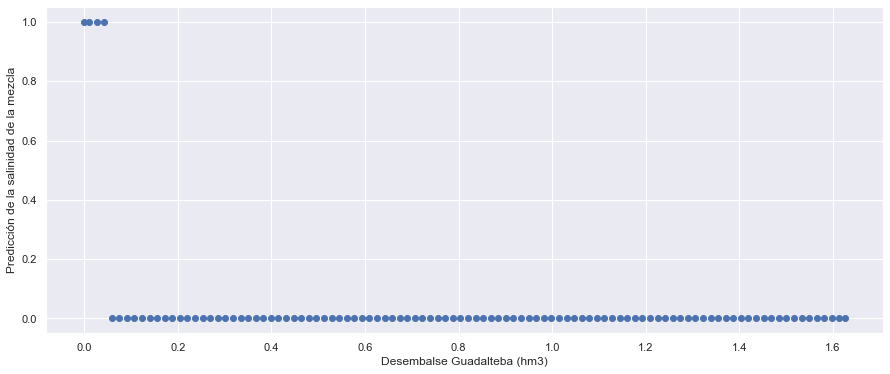

In [460]:
#Predicción de la Salinidad_mezcla en función de "Volumen_desembalse_guadalteba"

#Extraemos los valores máximos y mínimos de la variable "Volumen_desembalse_guadalteba" y elegimos 102 elementos para evaluar
#el predictor. Estos elementos se normalizan ya que el predictor está optimizado para valores normalizados.
max_val_des=[max(df_dam_x["Volumen_desembalse_guadalteba"])]
max_val_des=pd.DataFrame(max_val_des)
min_val_des=[min(df_dam_x["Volumen_desembalse_guadalteba"])]
min_val_des=pd.DataFrame(min_val_des)
v_salt_des=np.arange(0.01, 1.626, 0.0162)
v_salt_des=pd.DataFrame(v_salt_des)
v_salt_des=pd.concat([min_val_des, v_salt_des]).reset_index(drop = True) 
v_salt_des=v_salt_des.append(max_val_des,ignore_index=True)
v_salt_des=v_salt_des.rename(columns={0:"Volumen_desembalse_guadalteba"})
scaler=MinMaxScaler()
v_salt_des_norm=scaler.fit_transform(v_salt_des)
v_salt_des_norm=pd.DataFrame(v_salt_des_norm,columns=["Volumen_desembalse_guadalteba"])


v_1=df_dam_feat["Caudal_riego"].median()
v_2=df_dam_feat["Volumen_riego"].median()
v_3=df_dam_feat["Volumen_evaporado_guadalteba"].median()
v_4=df_dam_feat["Salinidad_guadalhorce"].median()
v_5=df_dam_feat["Cota_guadalteba"].median()
v_6=df_dam_feat["Volumen_embalsado_guadalhorce"].median()
v_7=df_dam_feat["Volumen_total_guadalhorce_guadalteba"].median()
v_8=df_dam_feat["Temperatura_Max"].median()
v_9=df_dam_feat["Volumen_embalsado_guadalteba"].median()
v_10=df_dam_feat["Cota_guadalhorce"].median()
v_11=df_dam_feat["Evaporacion"].median()
v_12=df_dam_feat["Temperatura_Min"].median()
v_13=df_dam_feat["Volumen_total_demandas"].median()
v_14=df_dam_feat["Caudal_total_demandas"].median()
v_15=df_dam_feat["Total_volumen_abastecido"].median()
v_16=df_dam_feat["Cota_conde"].median()
v_17=df_dam_feat["Volumen_total_guadalhorce_guadalteba_conde"].median()
v_18=df_dam_feat["Volumen_embalsado_conde"].median()
v_19=df_dam_feat["Anyo"].median()

v_1=np.full(shape=102,fill_value=v_1)
v_1=pd.DataFrame(v_1)
v_2=np.full(shape=102,fill_value=v_2)
v_2=pd.DataFrame(v_2)
v_3=np.full(shape=102,fill_value=v_3)
v_3=pd.DataFrame(v_3)
v_4=np.full(shape=102,fill_value=v_4)
v_4=pd.DataFrame(v_4)
v_5=np.full(shape=102,fill_value=v_5)
v_5=pd.DataFrame(v_5)
v_6=np.full(shape=102,fill_value=v_6)
v_6=pd.DataFrame(v_6)
v_7=np.full(shape=102,fill_value=v_7)
v_7=pd.DataFrame(v_7)
v_8=np.full(shape=102,fill_value=v_8)
v_8=pd.DataFrame(v_8)
v_9=np.full(shape=102,fill_value=v_9)
v_9=pd.DataFrame(v_9)
v_10=np.full(shape=102,fill_value=v_10)
v_10=pd.DataFrame(v_10)
v_11=np.full(shape=102,fill_value=v_11)
v_11=pd.DataFrame(v_11)
v_12=np.full(shape=102,fill_value=v_12)
v_12=pd.DataFrame(v_12)
v_13=np.full(shape=102,fill_value=v_13)
v_13=pd.DataFrame(v_13)
v_14=np.full(shape=102,fill_value=v_14)
v_14=pd.DataFrame(v_14)
v_15=np.full(shape=102,fill_value=v_15)
v_15=pd.DataFrame(v_15)
v_16=np.full(shape=102,fill_value=v_16)
v_16=pd.DataFrame(v_16)
v_17=np.full(shape=102,fill_value=v_17)
v_17=pd.DataFrame(v_17)
v_18=np.full(shape=102,fill_value=v_18)
v_18=pd.DataFrame(v_18)
v_19=np.full(shape=102,fill_value=v_19)
v_19=pd.DataFrame(v_19)


column_names=["Caudal_riego","Volumen_riego","Volumen_evaporado_guadalteba","Cota_guadalhorce","Cota_guadalteba",
             "Volumen_embalsado_guadalhorce","Salinidad_guadalhorce","Volumen_total_guadalhorce_guadalteba",
             "Temperatura_Max","Volumen_embalsado_guadalteba","Volumen_total_guadalhorce_guadalteba_conde",
             "Evaporacion","Temperatura_Min","Volumen_total_demandas","Caudal_total_demandas",
             "Total_volumen_abastecido","Cota_conde","Volumen_desembalse_guadalteba","Volumen_embalsado_conde",
             "Anyo"]

df_des_eval=pd.concat([v_1,v_2,v_3,v_10,v_5,v_6,v_4,v_7,v_8,v_9,v_17,v_11,v_12,v_13,v_14,v_15,v_16,v_salt_des,v_18
                    ,v_19],axis=1)
df_des_eval.columns=column_names


#Usamos el mejor predictor sobre el dataframe creado

#Deshacemos la normalización en la variable "Volumen_desembalse_guadalteba" para ver la clasificación de "Salinidad_mezcla"
#en función de los valores reales de "Volumen_desembalse_guadalteba"
des_eval=scaler.inverse_transform(v_salt_des_norm)
result_eval_des=gscv_result_rf.best_estimator_.predict(df_des_eval)
fig = plt.figure(figsize=(15,6))
plt.scatter(des_eval,result_eval_des)
plt.xlabel("Desembalse Guadalteba (hm3)")
plt.ylabel("Predicción de la salinidad de la mezcla")

Text(0, 0.5, 'Predicción de la salinidad de la mezcla')

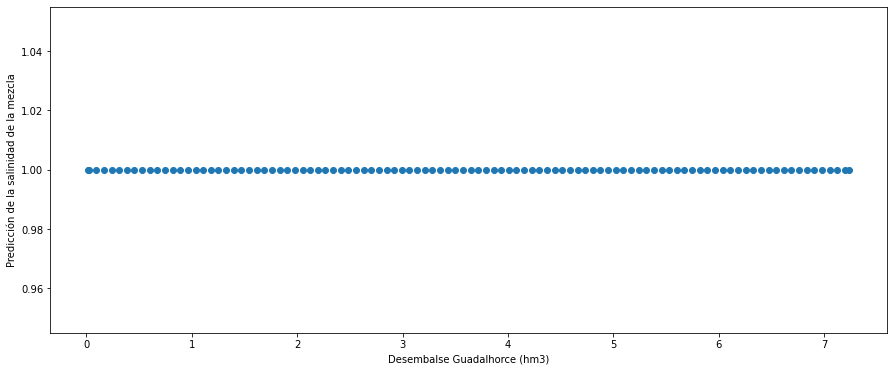

In [395]:
#Predicción de la Salinidad_mezcla en función de "Volumen_desembalse_guadalhorce"

#Extraemos los valores máximos y mínimos de la variable "Volumen_desembalse_guadalhorce" y elegimos 102 elementos para evaluar
#el predictor. Estos elementos se normalizan ya que el predictor está optimizado para valores normalizados.
max_val_des2=[max(df_dam_x["Volumen_desembalse_guadalhorce"])]
max_val_des2=pd.DataFrame(max_val_des2)
min_val_des2=[min(df_dam_x["Volumen_desembalse_guadalhorce"])]
min_val_des2=pd.DataFrame(min_val_des2)
v_salt_des2=np.arange(0.021, 7.240, 0.0725)
v_salt_des2=pd.DataFrame(v_salt_des2)
v_salt_des2=pd.concat([min_val_des2, v_salt_des2]).reset_index(drop = True) 
v_salt_des2=v_salt_des2.append(max_val_des2,ignore_index=True)
v_salt_des2=v_salt_des2.rename(columns={0:"Volumen_desembalse_guadalhorce"})
scaler=MinMaxScaler()
v_salt_des2_norm=scaler.fit_transform(v_salt_des2)
v_salt_des2_norm=pd.DataFrame(v_salt_des2_norm,columns=["Volumen_desembalse_guadalhorce"])


v_1=df_dam_feat["Caudal_riego"].median()
v_2=df_dam_feat["Volumen_riego"].median()
v_3=df_dam_feat["Volumen_evaporado_guadalteba"].median()
v_4=df_dam_feat["Cota_guadalhorce"].median()
v_5=df_dam_feat["Cota_guadalteba"].median()
v_6=df_dam_feat["Volumen_embalsado_guadalhorce"].median()
v_7=df_dam_feat["Salinidad_guadalhorce"].median()
v_8=df_dam_feat["Volumen_total_guadalhorce_guadalteba"].median()
v_9=df_dam_feat["Temperatura_Max"].median()
v_10=df_dam_feat["Volumen_embalsado_guadalteba"].median()
v_11=df_dam_feat["Volumen_total_guadalhorce_guadalteba_conde"].median()
v_12=df_dam_feat["Evaporacion"].median()
v_13=df_dam_feat["Temperatura_Min"].median()
v_14=df_dam_feat["Volumen_total_demandas"].median()
v_15=df_dam_feat["Caudal_total_demandas"].median()
v_16=df_dam_feat["Total_volumen_abastecido"].mean()
v_17=df_dam_feat["Cota_conde"].median()
v_18=df_dam_feat["Volumen_desembalse_guadalteba"].mean()
v_19=df_dam_feat["Volumen_embalsado_conde"].median()
v_20=df_dam_feat["Anyo"].median()
v_21=df_dam_feat["Caudal_desembalse_guadalteba"].median()
v_22=df_dam_feat["Volumen_abasteciemiento"].median()
v_23=df_dam_feat["Variacion_volumen_guadalteba"].median()
v_24=df_dam_feat["Caudal_desembalse_guadalhorce"].median()
v_25=df_dam_feat["Caudal_abastencimiento"].median() 
v_26=df_dam_feat["Aportacion_aparente_guadalhorce"].median()
v_27=df_dam_feat["Salinidad_conde"].median()
v_28=df_dam_feat["Aportacion_aparente_total_guadalhorce_guadalteba"].median()
v_29=df_dam_feat["Salinidad_guadalteba"].median()
v_30=df_dam_feat["Aportacion_aparente_total_guadalhorce_guadalteba_conde"].median()
v_31=df_dam_feat["Variacion_total_guadalhorce_guadalteba"].median()
v_32=df_dam_feat["Variacion_total_guadalhorce_guadalteba_conde"].median()
v_33=df_dam_feat["Toneladas_sal_guadalteba"].median()
v_34=df_dam_feat["Aportacion_aparente_guadalteba"].median()
v_35=df_dam_feat["Toneladas_sal_conde"].median()
v_36=df_dam_feat["Lluvia"].median()
v_37=df_dam_feat["Variacion_volumen_guadalhorce"].median()
v_38=df_dam_feat["Variacion_volumen_conde"].median()
v_39=df_dam_feat["Aportacion_aparente_conde"].median()


v_1=np.full(shape=102,fill_value=v_1)
v_1=pd.DataFrame(v_1)
v_2=np.full(shape=102,fill_value=v_2)
v_2=pd.DataFrame(v_2)
v_3=np.full(shape=102,fill_value=v_3)
v_3=pd.DataFrame(v_3)
v_4=np.full(shape=102,fill_value=v_4)
v_4=pd.DataFrame(v_4)
v_5=np.full(shape=102,fill_value=v_5)
v_5=pd.DataFrame(v_5)
v_6=np.full(shape=102,fill_value=v_6)
v_6=pd.DataFrame(v_6)
v_7=np.full(shape=102,fill_value=v_7)
v_7=pd.DataFrame(v_7)
v_8=np.full(shape=102,fill_value=v_8)
v_8=pd.DataFrame(v_8)
v_9=np.full(shape=102,fill_value=v_9)
v_9=pd.DataFrame(v_9)
v_10=np.full(shape=102,fill_value=v_10)
v_10=pd.DataFrame(v_10)
v_11=np.full(shape=102,fill_value=v_11)
v_11=pd.DataFrame(v_11)
v_12=np.full(shape=102,fill_value=v_12)
v_12=pd.DataFrame(v_12)
v_13=np.full(shape=102,fill_value=v_13)
v_13=pd.DataFrame(v_13)
v_14=np.full(shape=102,fill_value=v_14)
v_14=pd.DataFrame(v_14)
v_15=np.full(shape=102,fill_value=v_15)
v_15=pd.DataFrame(v_15)
v_16=np.full(shape=102,fill_value=v_16)
v_16=pd.DataFrame(v_16)
v_17=np.full(shape=102,fill_value=v_17)
v_17=pd.DataFrame(v_17)
v_18=np.full(shape=102,fill_value=v_18)
v_18=pd.DataFrame(v_18)
v_19=np.full(shape=102,fill_value=v_19)
v_19=pd.DataFrame(v_19)
v_20=np.full(shape=102,fill_value=v_20)
v_20=pd.DataFrame(v_20)
v_21=np.full(shape=102,fill_value=v_21)
v_21=pd.DataFrame(v_21)
v_22=np.full(shape=102,fill_value=v_22)
v_22=pd.DataFrame(v_22)
v_23=np.full(shape=102,fill_value=v_23)
v_23=pd.DataFrame(v_23)
v_24=np.full(shape=102,fill_value=v_24)
v_24=pd.DataFrame(v_24)
v_25=np.full(shape=102,fill_value=v_25)
v_25=pd.DataFrame(v_25)
v_26=np.full(shape=102,fill_value=v_26)
v_26=pd.DataFrame(v_26)
v_27=np.full(shape=102,fill_value=v_27)
v_27=pd.DataFrame(v_27)
v_28=np.full(shape=102,fill_value=v_28)
v_28=pd.DataFrame(v_28)
v_29=np.full(shape=102,fill_value=v_29)
v_29=pd.DataFrame(v_29)
v_30=np.full(shape=102,fill_value=v_30)
v_30=pd.DataFrame(v_30)
v_31=np.full(shape=102,fill_value=v_31)
v_31=pd.DataFrame(v_31)
v_32=np.full(shape=102,fill_value=v_32)
v_32=pd.DataFrame(v_32)
v_33=np.full(shape=102,fill_value=v_33)
v_33=pd.DataFrame(v_33)
v_34=np.full(shape=102,fill_value=v_34)
v_34=pd.DataFrame(v_34)
v_35=np.full(shape=102,fill_value=v_35)
v_35=pd.DataFrame(v_35)
v_36=np.full(shape=102,fill_value=v_36)
v_36=pd.DataFrame(v_36)
v_37=np.full(shape=102,fill_value=v_37)
v_37=pd.DataFrame(v_37)
v_38=np.full(shape=102,fill_value=v_38)
v_38=pd.DataFrame(v_38)
v_39=np.full(shape=102,fill_value=v_39)
v_39=pd.DataFrame(v_39)


column_names3=["Caudal_riego","Volumen_riego","Volumen_evaporado_guadalteba","Cota_guadalhorce","Cota_guadalteba",
             "Volumen_embalsado_guadalhorce","Salinidad_guadalhorce","Volumen_total_guadalhorce_guadalteba",
             "Temperatura_Max","Volumen_embalsado_guadalteba","Volumen_total_guadalhorce_guadalteba_conde",
             "Evaporacion","Temperatura_Min","Volumen_total_demandas","Caudal_total_demandas",
             "Total_volumen_abastecido","Cota_conde","Volumen_desembalse_guadalteba","Volumen_embalsado_conde",
             "Anyo","Caudal_desembalse_guadalteba","Volumen_abasteciemiento","Variacion_volumen_guadalteba","Caudal_desembalse_guadalhorce",
"Caudal_abastencimiento","Aportacion_aparente_guadalhorce","Salinidad_conde","Aportacion_aparente_total_guadalhorce_guadalteba",
"Salinidad_guadalteba","Aportacion_aparente_total_guadalhorce_guadalteba_conde","Variacion_total_guadalhorce_guadalteba",
"Variacion_total_guadalhorce_guadalteba_conde","Toneladas_sal_guadalteba","Volumen_desembalse_guadalhorce",
"Aportacion_aparente_guadalteba","Toneladas_sal_conde","Lluvia","Variacion_volumen_guadalhorce","Variacion_volumen_conde",
"Aportacion_aparente_conde"]

df_des2_eval=pd.concat([v_1,v_2,v_3,v_10,v_5,v_6,v_4,v_7,v_8,v_9,v_17,v_11,v_12,v_13,v_14,v_15,v_16,v_18,v_19,
                       v_20,v_21,v_22,v_23,v_24,v_25,v_26,v_27,v_28,v_29,v_30,v_31,v_32,v_33,v_salt_des2,v_34,
                        v_35,v_36,v_37,v_38,v_39],axis=1)
df_des2_eval.columns=column_names3


#Usamos el mejor predictor sobre el dataframe creado

#Deshacemos la normalización en la variable "Volumen_desembalse_guadalhorce" para ver la clasificación de "Salinidad_mezcla"
#en función de los valores reales de "Volumen_desembalse_guadalhorce"
des2_eval=scaler.inverse_transform(v_salt_des2_norm)
result_eval_des2=gscv_result_rf.best_estimator_.predict(df_des2_eval)
fig = plt.figure(figsize=(15,6))
plt.scatter(des2_eval,result_eval_des2)
plt.xlabel("Desembalse Guadalhorce (hm3)")
plt.ylabel("Predicción de la salinidad de la mezcla")

### 6.4.2 Distribución de variable etiquetada trás métodos de imputación de NAN

IMPORTANTE: 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var, dtype: float64
count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var_mean, dtype: float64


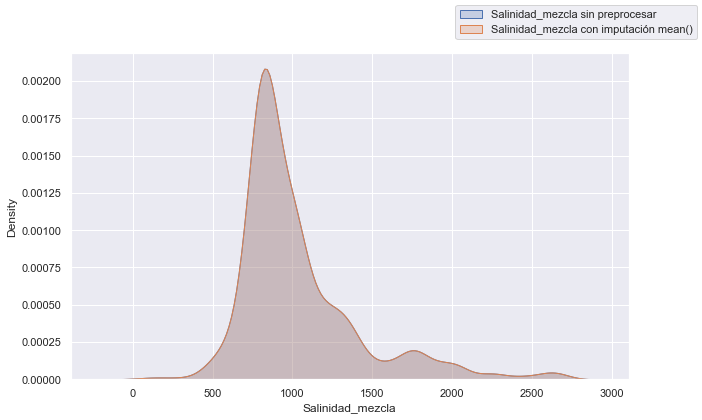

In [224]:
#Distribución de los valores en la variable Salinidad_mezcla con NANs y la variable Salinidad_mezcla con imputación 
#con mean()
plt_df=pd.DataFrame({'var':df_data['Salinidad_mezcla'],'var_mean':df_data['Salinidad_mezcla'].fillna((df_data['Salinidad_mezcla'].mean()))})

fig = plt.figure(figsize=(10,6))
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(plt_df[['var']], hist=False,label="Variable Salinidad_mezcla sin preprocesar",kde_kws={"shade": True})
sns.distplot(plt_df[['var_mean']],axlabel="Salinidad_mezcla", hist=False, kde_kws={"shade": True})
fig.legend(labels=['Salinidad_mezcla sin preprocesar','Salinidad_mezcla con imputación mean()'])
print(plt_df['var'].describe())
print(plt_df['var_mean'].describe())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var, dtype: float64
count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var_median, dtype: float64


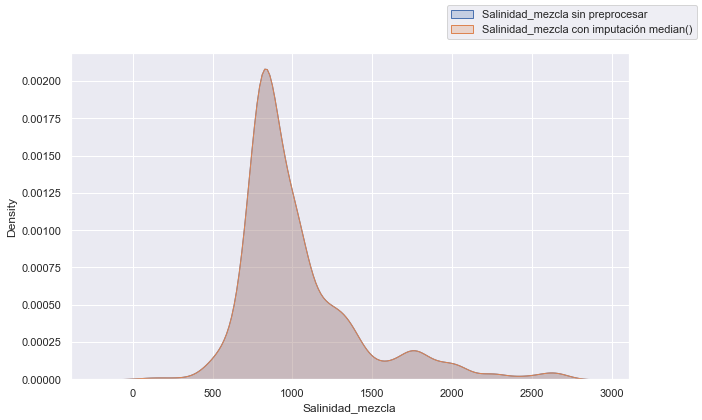

In [225]:
#Distribución de los valores en la variable Salinidad_mezcla con NANs y la variable Salinidad_mezcla con imputación 
#con median()
plt_df=pd.DataFrame({'var':df_data['Salinidad_mezcla'],'var_median':df_data['Salinidad_mezcla'].fillna((df_data['Salinidad_mezcla'].median()))})

fig = plt.figure(figsize=(10,6))
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(plt_df[['var']], hist=False,label="Variable Salinidad_mezcla sin preprocesar",kde_kws={"shade": True})
sns.distplot(plt_df[['var_median']],axlabel="Salinidad_mezcla", hist=False, kde_kws={"shade": True})
fig.legend(labels=['Salinidad_mezcla sin preprocesar','Salinidad_mezcla con imputación median()'])
print(plt_df['var'].describe())
print(plt_df['var_median'].describe())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var, dtype: float64
count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var_roll_mean, dtype: float64


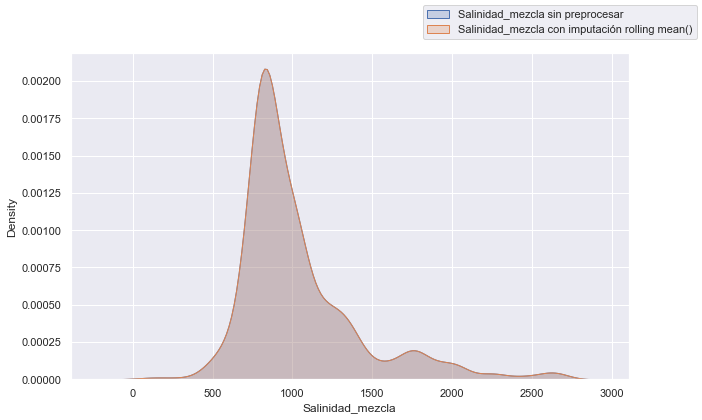

In [226]:
#Distribución de los valores en la variable Salinidad_mezcla con NANs y la variable Salinidad_mezcla con imputación 
#con rolling mean()
window=30
plt_df_roll_mean=pd.DataFrame({'var':df_data['Salinidad_mezcla'],'var_roll_mean':df_data['Salinidad_mezcla'].fillna((df_data['Salinidad_mezcla'].rolling(window,min_periods=1,).mean()))})

fig = plt.figure(figsize=(10,6))
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(plt_df_roll_mean[['var']], hist=False,label="Variable Salinidad_mezcla sin preprocesar",kde_kws={"shade": True})
sns.distplot(plt_df_roll_mean[['var_roll_mean']],axlabel="Salinidad_mezcla", hist=False, kde_kws={"shade": True})
fig.legend(labels=['Salinidad_mezcla sin preprocesar','Salinidad_mezcla con imputación rolling mean()'])
print(plt_df_roll_mean['var'].describe())
print(plt_df_roll_mean['var_roll_mean'].describe())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var, dtype: float64
count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var_roll_median, dtype: float64


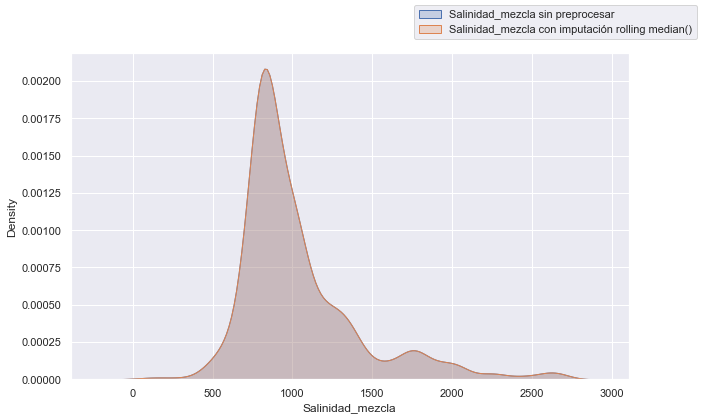

In [227]:
#Distribución de los valores en la variable Salinidad_mezcla con NANs y la variable Salinidad_mezcla con imputación 
#con rolling median()
window=30
plt_df_roll_median=pd.DataFrame({'var':df_data['Salinidad_mezcla'],'var_roll_median':df_data['Salinidad_mezcla'].fillna((df_data['Salinidad_mezcla'].rolling(window,min_periods=1,).median()))})

fig = plt.figure(figsize=(10,6))
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(plt_df_roll_median[['var']], hist=False,label="Variable Salinidad_mezcla sin preprocesar",kde_kws={"shade": True})
sns.distplot(plt_df_roll_median[['var_roll_median']],axlabel="Salinidad_mezcla", hist=False, kde_kws={"shade": True})
fig.legend(labels=['Salinidad_mezcla sin preprocesar','Salinidad_mezcla con imputación rolling median()'])
print(plt_df_roll_median['var'].describe())
print(plt_df_roll_median['var_roll_median'].describe())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var, dtype: float64
count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var_linear_inter, dtype: float64


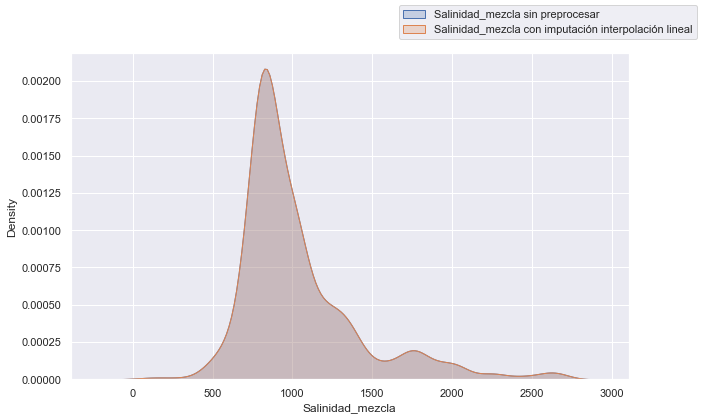

In [228]:
#Distribución de los valores en la variable Salinidad_mezcla con NANs y la variable Salinidad_mezcla con imputación 
#con interpolación lineal
plt_df_linear_inter=pd.DataFrame({'var':df_data['Salinidad_mezcla'],'var_linear_inter':df_data.Salinidad_mezcla.interpolate(method='linear')})

fig = plt.figure(figsize=(10,6))
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(plt_df_linear_inter[['var']], hist=False,label="Variable Salinidad_mezcla sin preprocesar",kde_kws={"shade": True})
sns.distplot(plt_df_linear_inter[['var_linear_inter']],axlabel="Salinidad_mezcla", hist=False, kde_kws={"shade": True})
fig.legend(labels=['Salinidad_mezcla sin preprocesar','Salinidad_mezcla con imputación interpolación lineal'])
print(plt_df_linear_inter['var'].describe())
print(plt_df_linear_inter['var_linear_inter'].describe())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var, dtype: float64
count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var_linear_quad, dtype: float64


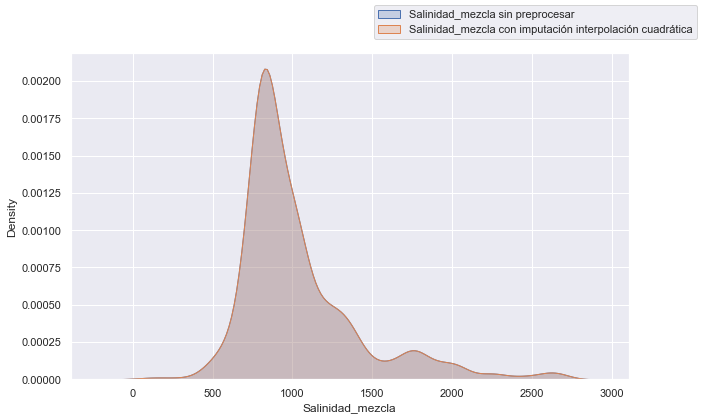

In [229]:
#Distribución de los valores en la variable Salinidad_mezcla con NANs y la variable Salinidad_mezcla con imputación 
#con interpolación cuadrática
plt_df_linear_quad=pd.DataFrame({'var':df_data['Salinidad_mezcla'],'var_linear_quad':df_data.Salinidad_mezcla.interpolate(method='quadratic')})

fig = plt.figure(figsize=(10,6))
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(plt_df_linear_quad[['var']], hist=False,label="Variable Salinidad_mezcla sin preprocesar",kde_kws={"shade": True})
sns.distplot(plt_df_linear_quad[['var_linear_quad']],axlabel="Salinidad_mezcla", hist=False, kde_kws={"shade": True})
fig.legend(labels=['Salinidad_mezcla sin preprocesar','Salinidad_mezcla con imputación interpolación cuadrática'])
print(plt_df_linear_quad['var'].describe())
print(plt_df_linear_quad['var_linear_quad'].describe())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var, dtype: float64
count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var_linear_cubic, dtype: float64


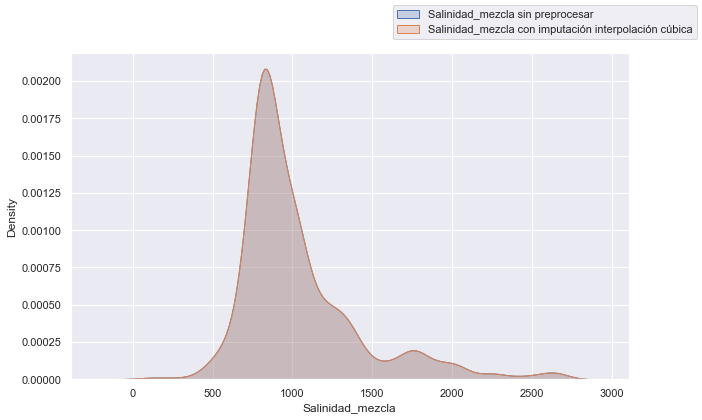

In [230]:
#Distribución de los valores en la variable Salinidad_mezcla con NANs y la variable Salinidad_mezcla con imputación 
#con interpolación cúbica
plt_df_linear_cubic=pd.DataFrame({'var':df_data['Salinidad_mezcla'],'var_linear_cubic':df_data.Salinidad_mezcla.interpolate(method='cubic')})

fig = plt.figure(figsize=(10,6))
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(plt_df_linear_cubic[['var']], hist=False,label="Variable Salinidad_mezcla sin preprocesar",kde_kws={"shade": True})
sns.distplot(plt_df_linear_cubic[['var_linear_cubic']],axlabel="Salinidad_mezcla", hist=False, kde_kws={"shade": True})
fig.legend(labels=['Salinidad_mezcla sin preprocesar','Salinidad_mezcla con imputación interpolación cúbica'])
print(plt_df_linear_cubic['var'].describe())
print(plt_df_linear_cubic['var_linear_cubic'].describe())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var, dtype: float64
count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var_linear_akima, dtype: float64


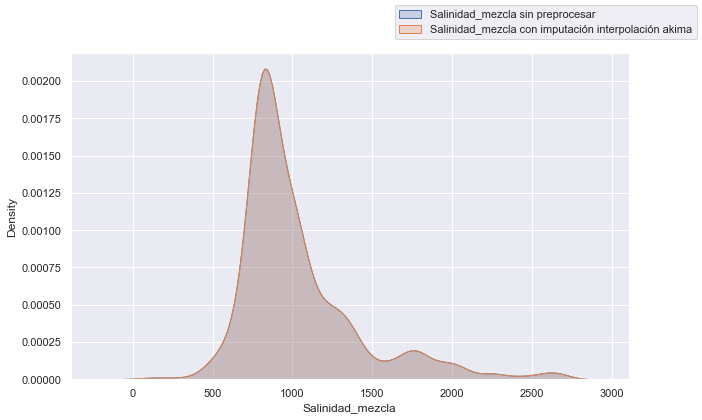

In [231]:
#Distribución de los valores en la variable Salinidad_mezcla con NANs y la variable Salinidad_mezcla con imputación 
#con interpolación akima
plt_df_linear_akima=pd.DataFrame({'var':df_data['Salinidad_mezcla'],'var_linear_akima':df_data.Salinidad_mezcla.interpolate(method='akima')})

fig = plt.figure(figsize=(10,6))
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(plt_df_linear_akima[['var']], hist=False,label="Variable Salinidad_mezcla sin preprocesar",kde_kws={"shade": True})
sns.distplot(plt_df_linear_akima[['var_linear_akima']],axlabel="Salinidad_mezcla", hist=False, kde_kws={"shade": True})
fig.legend(labels=['Salinidad_mezcla sin preprocesar','Salinidad_mezcla con imputación interpolación akima'])
print(plt_df_linear_akima['var'].describe())
print(plt_df_linear_akima['var_linear_akima'].describe())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var, dtype: float64
count    2894.000000
mean     1030.223290
std       379.230801
min         1.170000
25%       800.400000
50%       901.000000
75%      1140.500000
max      2714.000000
Name: var_linear_spline, dtype: float64


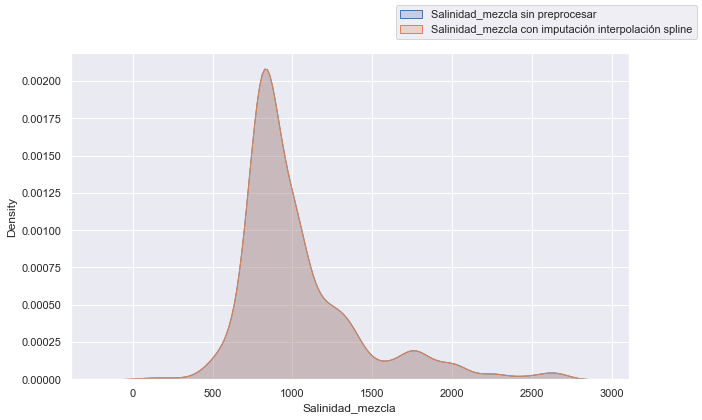

In [232]:
#Distribución de los valores en la variable Salinidad_mezcla con NANs y la variable Salinidad_mezcla con imputación 
#con interpolación spline
plt_df_linear_spline=pd.DataFrame({'var':df_data['Salinidad_mezcla'],'var_linear_spline':df_data.Salinidad_mezcla.interpolate(method='spline',order=3)})

fig = plt.figure(figsize=(10,6))
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(plt_df_linear_spline[['var']], hist=False,label="Variable Salinidad_mezcla sin preprocesar",kde_kws={"shade": True})
sns.distplot(plt_df_linear_spline[['var_linear_spline']],axlabel="Salinidad_mezcla", hist=False, kde_kws={"shade": True})
fig.legend(labels=['Salinidad_mezcla sin preprocesar','Salinidad_mezcla con imputación interpolación spline'])
print(plt_df_linear_spline['var'].describe())
print(plt_df_linear_spline['var_linear_spline'].describe())

In [233]:
#-----------------------------------------------------------------------------

In [234]:
#REFERENCIAS

#1. https://stackoverflow.com/questions/58072683/combine-year-month-and-day-in-python-to-create-a-date
#2. https://stackoverflow.com/questions/52291519/pandas-cant-convert-datetime-yyyy-mm-dd-to-dd-mm-yyyy
#3. https://stackoverflow.com/questions/25122099/move-column-by-name-to-front-of-table-in-pandas
#4. https://matthew-brett.github.io/teaching/string_formatting.html
#5. https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
#6. https://stackoverflow.com/questions/22216076/unicodedecodeerror-utf8-codec-cant-decode-byte-0xa5-in-position-0-invalid-s
#7. https://www.delftstack.com/howto/python-pandas/how-to-delete-dataframe-row-in-pandas-based-on-column-value/
#8. https://stackoverflow.com/questions/37724225/how-to-categorize-floating-values-in-python-using-pandas-library
#9. https://www.youtube.com/watch?v=mnKm3YP56PY
#10.https://www.researchgate.net/publication/224196395_Feature_Selection_Using_Principal_Component_Analysis
#11.https://machinelearningmastery.com/feature-selection-machine-learning-python/
#12.https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
#13.https://medium.com/@nmscott14/3-feature-selection-methods-e7ccd6dbf316
#14.https://towardsdatascience.com/predict-missing-values-in-the-dataset-897912a54b7b
#15.https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f
#16.https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7
#17.https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/